In [189]:
import numpy as np
import scipy as sc
import math
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf
import matplotlib as mpl


import pymc3
import  logistic
import run_covering_2
import warnings
warnings.filterwarnings('ignore')

import groups_tools as gt #the important homemade module

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [148]:
folder = "run_manuscript"

# Groups

In [331]:
R = pd.read_csv("R_final_manuscript.csv", index_col = False)
G = pd.read_csv("G_final_manuscript.csv", index_col = False)

In [332]:
sed_logMass_closest = []
Mvir_closest = []
Rvir_closest = []
for i, g in G.iterrows():
    rr = R[R["group_id"] == g["group_id"]]
    bmin = np.min(rr["B_KPC"])
    rrmin = rr[rr["B_KPC"] == bmin]
    zz = rrmin["Z"].values[0]
    mass = rrmin["sed_logMass"].values[0]
    #print(mass, zz)
    try:
        Mvir = gt.Behroozi_2019(mass, zz)
    except:
        Mvir = 0
    Rvir = gt.get_Rvir(10**Mvir, zz)
    
    sed_logMass_closest.append(mass)
    Mvir_closest.append(Mvir)
    Rvir_closest.append(Rvir)

sed_logMass_closest = np.array(sed_logMass_closest)
Mvir_closest = np.array(Mvir_closest)
Rvir_closest = np.array(Rvir_closest)

G["sed_logMass_closest"] = sed_logMass_closest
G["Mvir_closest"] = Mvir_closest
G["Rvir_closest"] = Rvir_closest

In [333]:
G["b_min_kpc_norm"] = G["b_min_kpc"]/G["Rvir_closest"]

In [334]:
G["bool_abs_01"] = (G["REW_2796"] > 0.1)*1
G["bool_abs_03"] = (G["REW_2796"] > 0.3)*1
G["bool_abs_1"] = (G["REW_2796"] > 1)*1

In [335]:
f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
#f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f_N_5 = G["N_gal"] >= 5
f_N_4 = G["N_gal"] >= 4
f_N_3 = G["N_gal"] >= 3
f_N9_5 = G["N_gal_9"] >= 5
f_N9_4 = G["N_gal_9"] >= 4
f_N9_3 = G["N_gal_9"] >= 3
f10 = G["bool_absorption"] == 0
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True
#f24 = G["ID"].isin(good_grp)

f15 = R["B_KPC"] <= 100
#f16 = R["N100_los"] <= 2
#f17 = R["N100_los"] <= 1
f18 = R["N50_neighb"] == 0
f19 = R["Z"] >= 4700/2796 - 1
f20 = R["Z"] <= 9300/2796 - 1
f21 = R["bool_absorption"] == 0
f22 = R["bool_absorption"] == 1
f23 = R["B_KPC"]>= 5 # remove the QSOs
#fweirds = G["Rvir_recomputed"] >= 10

In [336]:
G_abs = G[f8 & f14 & f13]
G_noabs = G[f10 & f14 & f13]
#G2 = G[f7 & f13 & f14]
#G2_abs = G[f8 & f7 & f14 & f13]
#G2_noabs = G[f10 & f7 & f14 & f13]
G5 = G[f_N_5 & f13 & f14]
G5_abs = G5[G5["bool_absorption"] == 1]
G5_noabs = G5[G5["bool_absorption"] == 0]
G4_nocov = G[f_N_4 & ~f13]
G4_nobehind = G[f_N_4 & ~f14]
G4_raw = G[f_N_4]
G4_9_raw = G[f_N9_4]
G4 = G[f_N_4 & f13 & f14]
G4_abs = G4[G4["bool_absorption"] == 1]
G4_noabs = G4[G4["bool_absorption"] == 0]
G3 = G[f_N_3 & f13 & f14]
G3_abs = G4[G4["bool_absorption"] == 1]
G3_noabs = G4[G4["bool_absorption"] == 0]


G5_9 = G[f_N9_5 & f13 & f14]
G5_9_abs = G5_9[G5_9["bool_absorption"] == 1]
G5_9_noabs = G5_9[G5_9["bool_absorption"] == 0]
G4_9 = G[f_N9_4 & f13 & f14]
G4_9_abs = G4_9[G4_9["bool_absorption"] == 1]
G4_9_noabs = G4_9[G4_9["bool_absorption"] == 0]
G3_9 = G[f_N9_3 & f13 & f14]
G3_9_abs = G3_9[G3_9["bool_absorption"] == 1]
G3_9_noabs = G3_9[G3_9["bool_absorption"] == 0]

#R_ilane_abs = R[f22 & f15 & f17 & f18 & f23]
#R_ilane_noabs = R[f21 & f15 & f17 & f18  & f23]
#R_ilane2_abs = R[f22 & f17 & f18  & f23]
#R_ilane2_noabs = R[f21 & f17 & f18  & f23]

In [337]:
G4_9_bmin_lin = G4_9[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bcenter_lin = G4_9[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bmin_norm_lin = G4_9[["b_min_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bcenter_norm_lin = G4_9[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2"]]
G4_9_bmin_lin = G4_9_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bcenter_lin = G4_9_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bmin_norm_lin = G4_9_bmin_norm_lin.rename(columns = {"b_min_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bcenter_norm_lin = G4_9_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G4_9_bmin_log = G4_9_bmin_lin.copy()
G4_9_bcenter_log = G4_9_bcenter_lin.copy()
G4_9_bmin_norm_log = G4_9_bmin_norm_lin.copy()
G4_9_bcenter_norm_log = G4_9_bcenter_norm_lin.copy()
G4_9_bmin_log["log10(b)"] = np.log10(G4_9_bmin_lin["b"])
G4_9_bcenter_log["log10(b)"] = np.log10(G4_9_bcenter_lin["b"])
G4_9_bmin_norm_log["log10(b)"] = np.log10(G4_9_bmin_norm_lin["b"])
G4_9_bcenter_norm_log["log10(b)"] = np.log10(G4_9_bcenter_norm_lin["b"])
G4_9_bmin_norm_lin["log10(b)"] = G4_9_bmin_norm_lin["b"]
G4_9_bcenter_norm_lin["log10(b)"] = G4_9_bcenter_norm_lin["b"]

In [338]:
G4_9_bmin_lin.to_csv(folder + "/G4_9_mgii_bmin_lin.csv", index = False)
G4_9_bcenter_lin.to_csv(folder + "/G4_9_mgii_bcenter_lin.csv", index = False)
G4_9_bmin_log.to_csv(folder + "/G4_9_mgii_bmin_log.csv", index = False)
G4_9_bcenter_log.to_csv(folder + "/G4_9_mgii_bcenter_log.csv", index = False)
G4_9_bmin_norm_lin.to_csv(folder + "/G4_9_mgii_bmin_norm_lin.csv", index = False)
G4_9_bcenter_norm_lin.to_csv(folder + "/G4_9_mgii_bcenter_norm_lin.csv", index = False)
G4_9_bmin_norm_log.to_csv(folder + "/G4_9_mgii_bmin_norm_log.csv", index = False)
G4_9_bcenter_norm_log.to_csv(folder + "/G4_9_mgii_bcenter_norm_log.csv", index = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:13<00:00, 1511.56draws/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.044191 -10.641602 -7.465994 -4.674477 -2.666600 -1.532589
beta   2.338371   2.024940  2.129922  2.292642  2.566099  2.870333
alpha -4.7 [-10.64--1.53] (95\%) 
beta 2.3 [2.02-2.87] (95\%) 

WAIC 14.75 +/- 5.24 peff 1.05
WAIC deviance 12.659990715452594
LOO 14.80 +/- 5.27 peff 1.07
WBIC  22.58305815643096


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 16.3498
DIC Lmax 20.6050 2.13
Deviance best 16.4577
DIC best 20.4971 2.02
|               WAIC |                LOO |              WBIC |                DIC |
| 14.754489739096512 | 14.799182617554472 | 22.58305815643096 | 20.497132196451954 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.044191 -10.641602 -7.465994 -4.674477 -2.666600 -1.532589
beta   2.338371   2.024940  2.129922  2.292642  2.566099  2.870333


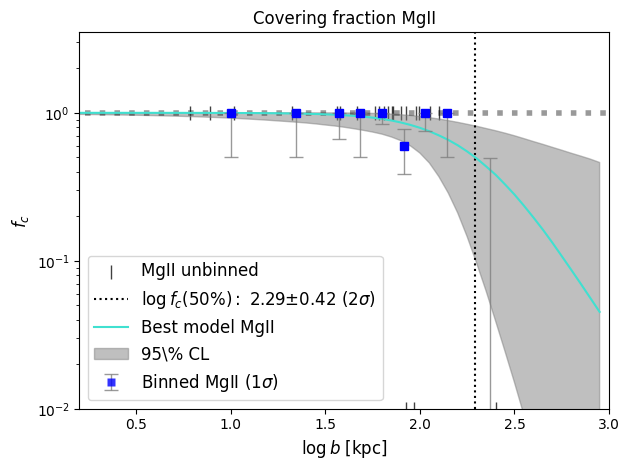

In [236]:
fc_G4_9_bmin_noz = run_covering_2.mgii(run = True, filename = folder + "/G4_9_mgii_bmin_log.csv", redshift = False, \
                                       Nsample = 9000, burnin = 500)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1554.26draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.576096 -11.087950 -8.151148 -5.185829 -3.127794 -1.892521
beta   2.579441   2.326702  2.419640  2.552022  2.755349  2.941726
alpha -5.2 [-11.09--1.89] (95\%) 
beta 2.6 [2.33-2.94] (95\%) 

WAIC 15.17 +/- 4.84 peff 1.01
WAIC deviance 13.142387912014708
LOO 15.20 +/- 4.86 peff 1.03
WBIC  23.230763041808782


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 18.0522
DIC Lmax 22.2781 2.11
Deviance best 18.1447
DIC best 22.1856 2.02
|               WAIC |                LOO |               WBIC |                DIC |
| 15.170949169716295 | 15.204551081669536 | 23.230763041808782 | 22.185550617265246 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.576096 -11.087950 -8.151148 -5.185829 -3.127794 -1.892521
beta   2.579441   2.326702  2.419640  2.552022  2.755349  2.941726


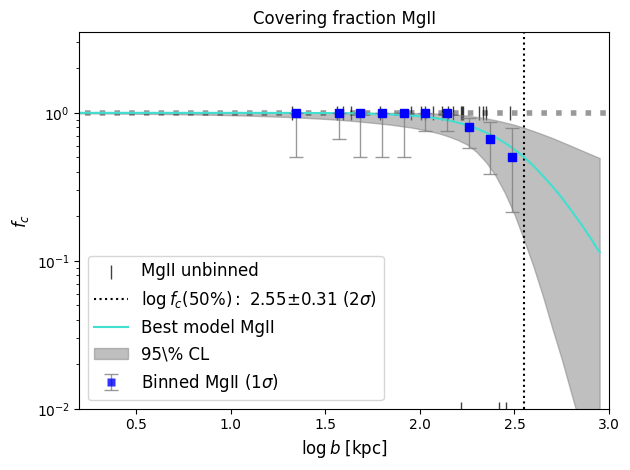

In [237]:
fc_G4_9_bcenter_noz = run_covering_2.mgii(run = True, filename = folder + "/G4_9_mgii_bcenter_log.csv", redshift = False)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


MgII_closest_only
Reading from None
LEN (Outcomes) 22
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.576096 -11.087950 -8.151148 -5.185829 -3.127794 -1.892521
beta   2.579441   2.326702  2.419640  2.552022  2.755349  2.941726


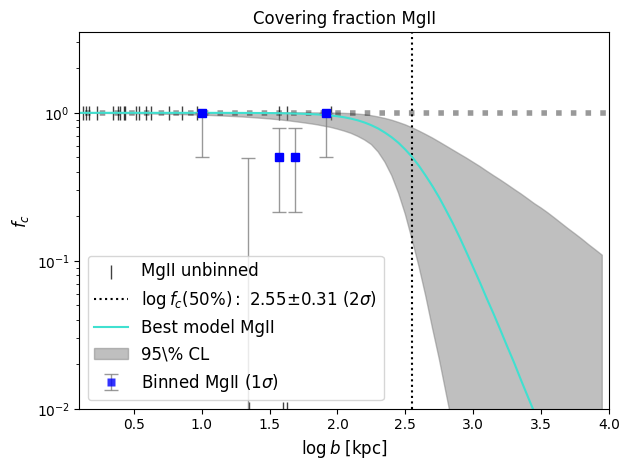

In [238]:
fc_G4_9_bcenter_norm = run_covering_2.mgii(run = False, filename = folder + "/G4_9_mgii_bcenter_norm_lin.csv", \
                                         redshift = False, xlim = [0.1, 4])

### Comparison with other results

In [239]:
logb = np.linspace(0.5, 3, 50)
logb_norm = np.linspace(0.05, 4)

In [71]:
Dutta_2020 = pd.read_csv("Dutta_2020.csv", index_col = False)
Dutta_2020_fcdiff = pd.read_csv("Dutta_2020_fcdiff.csv", index_col = False)
Dutta_2020_fcdiff01 = pd.read_csv("Dutta_2020_fcdiff01.csv", index_col = False)
Dutta_2020_fcdiff01

,R(kpc),fc01,fc01_inf,fc01_sup
0,30.768106,0.798018,0.551011,0.939595
1,90.384053,0.231708,0.216647,0.361237
2,150.000000,0.192549,0.126278,0.282917
3,210.505737,0.081094,0.044947,0.132303
4,271.011474,0.165438,0.102180,0.258819


In [72]:
def logistic(t):
    return 1/(1+np.exp(-t))
    
def logistic_eq6(A, C, logb):
    return logistic(A*(logb - C))

def logistic_eq7(A, B, C, logb, z):
    return logistic(A*(logb - B*np.log10(1+z) - C))

Il_6 = logistic_eq6(-4.7, 1.6, logb)
Il_7 = logistic_eq7(-4.2, 2.0, 1.0, logb, 0.9)
Il = np.array([logb, Il_6, Il_7])

Schroetter_2021 = pd.DataFrame(Il.T, columns = ["logb", "best_fit_b", "best_fit_bz"])

In [73]:
# For the CL intervals:
Schroetter_fc_sup = pd.read_csv("Schroetter_fc_sup.csv", index_col = False)
Schroetter_fc_inf = pd.read_csv("Schroetter_fc_inf.csv", index_col = False)

In [74]:
Sc_logb_sup = np.interp(logb, Schroetter_fc_sup["log_b_sup"], Schroetter_fc_sup["log_fc_sup"])
Sc_logb_inf = np.interp(logb, Schroetter_fc_inf["log_b_inf"], Schroetter_fc_inf["log_fc_inf"])

#### Nielsen 2013

In [75]:
Niels_b = [12.5, 37.5, 75, 150]
Niels_01 = [1, 0.94, 0.61, 0.29]
Niels_01_inf = [0.93, 0.89, 0.53, 0.19]
Niels_01_sup = [1, 0.97, 0.69, 0.41]
Niels_03 = [0.96, 0.79, 0.40, 0.25]
Niels_1 = [0.39, 0.31, 0.13, 0.06]
Niels = np.array([Niels_b, Niels_01, Niels_01_inf, Niels_01_sup, Niels_03, Niels_1])
Nielsen_2013 = pd.DataFrame(Niels.T, columns = ["b", "fc01", "fc01_inf", "fc01_sup", "fc03", "fc1"])

#### Bordoloi 2011

In [76]:
bordoloi_b = [20 ,50, 70, 100, 140, 180]
bordoloi_rew_group = [0.33 , 0.46, 0.39, 0.16, 0.15, 0.046] #upper limit for the last value
bordoloi_rew_nongroup = [0.48 , 0.38, 0.18, 0.04, 0.012, 0] #upper limit for the last value
bordoloi_sig_group = [0.09 , 0.07, 0.05, 0.04, 0.03, 0]
bordoloi_sig_nongroup = [0.05 , 0.05, 0.05, 0.02, 0, 0]
d = np.array([bordoloi_b, bordoloi_rew_group, bordoloi_rew_nongroup, bordoloi_sig_group, bordoloi_sig_nongroup])
bordoloi = pd.DataFrame(d.T, columns = ["bcenter_kpc", "rew_group", "rew_nongroup", "sigma_group", "sigma_nongroup"])
bordoloi

,bcenter_kpc,rew_group,rew_nongroup,sigma_group,sigma_nongroup
0,20.0,0.330,0.480,0.09,0.05
1,50.0,0.460,0.380,0.07,0.05
2,70.0,0.390,0.180,0.05,0.05
3,100.0,0.160,0.040,0.04,0.02
4,140.0,0.150,0.012,0.03,0.00
5,180.0,0.046,0.000,0.00,0.00


#### Huang 2021

In [77]:
Huang_b = [20, 70, 200, 500]
Huang_all = [0.87, 0.49, 0.19, 0.06]
Huang_all_sigma = [0.05, 0.06, 0.12, 0.06]
Huang_blue = [0.92, 0.56, 0.19, 0.08]
Huang_red = [0.67, 0.41, 0.09, 0.04]
Huang = np.array([Huang_b, Huang_all, Huang_all_sigma, Huang_blue, Huang_red])
Huang_2021 = pd.DataFrame(Huang.T, columns = ["b", "all","all_sigma", "blue", "red"])

### Fc for bcenter/Rvir

In [240]:
pbest_G4_9_bcenter_norm, plow_G4_9_bcenter_norm, phigh_G4_9_bcenter_norm = \
fc_G4_9_bcenter_norm.predict_2d(logb_norm, 1.0, params=fc_G4_9_bcenter_norm.trace)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Text(0, 0.5, '$f_c$')

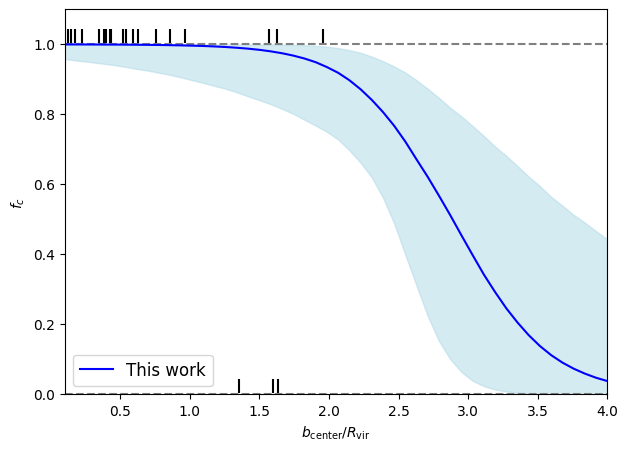

In [330]:
plt.figure(figsize = (7,5), dpi = 100)
plt.rcParams['lines.linewidth']=1.5
plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(logb_norm, plow, phigh, color = 'lightblue', alpha = 0.5)
plt.plot(logb_norm, pbest, label= "This work", color = "blue")
plt.scatter(fc_G4_9_bcenter_norm.log_flux, fc_G4_9_bcenter_norm.outcomes+0.025, marker = "|", color = "black",\
            s = 100)
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.00,1.1))
plt.xlim((0.1,4))
#plt.yscale("log")
plt.xlabel("$b_{\mathrm{center}}/ R_{\mathrm{vir}}$")
plt.ylabel("$f_c$")
#plt.xscale("log")

# Fc as a function of bnorm and REW threshold.

In [341]:
G4_9_bmin_norm_lin = G4_9[["b_min_kpc_norm", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2", "REW_2796"]]
G4_9_bcenter_norm_lin = G4_9[["b_center_kpc_norm2", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2", "REW_2796"]]
G4_9_bmin_norm_lin = G4_9_bmin_norm_lin.rename(columns = {"b_min_kpc_norm": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})
G4_9_bcenter_norm_lin = G4_9_bcenter_norm_lin.rename(columns = {"b_center_kpc_norm2": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G4_9_bmin_norm_log = G4_9_bmin_norm_lin.copy()
G4_9_bcenter_norm_log = G4_9_bcenter_norm_lin.copy()
G4_9_bmin_norm_log["log10(b)"] = np.log10(G4_9_bmin_norm_lin["b"])
G4_9_bcenter_norm_log["log10(b)"] = np.log10(G4_9_bcenter_norm_lin["b"])
G4_9_bmin_norm_lin["log10(b)"] = G4_9_bmin_norm_lin["b"]
G4_9_bcenter_norm_lin["log10(b)"] = G4_9_bcenter_norm_lin["b"]

In [342]:
G_01 = G4_9_bcenter_norm_lin.copy()
G_03 = G4_9_bcenter_norm_lin.copy()
G_05 = G4_9_bcenter_norm_lin.copy()

G_01["detection"] = G_01["REW_2796"]>= 0.1
G_03["detection"] = G_03["REW_2796"]>= 0.3
G_05["detection"] = G_05["REW_2796"]>= 0.5

G_01["detection"] = G_01["detection"].astype(int)
G_03["detection"] = G_03["detection"].astype(int)
G_05["detection"] = G_05["detection"].astype(int)

G_01_save = G_01[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_03_save = G_03[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_05_save = G_05[["group_id", "log10(b)","detection", "z_gal", "mass"]]

G_01_save.to_csv("fc_data/G_01_bcenter_norm.csv", index = False)
G_03_save.to_csv("fc_data/G_03_bcenter_norm.csv", index = False)
G_05_save.to_csv("fc_data/G_05_bcenter_norm.csv", index = False)

In [343]:
G_01 = G4_9_bmin_norm_lin.copy()
G_03 = G4_9_bmin_norm_lin.copy()
G_05 = G4_9_bmin_norm_lin.copy()

G_01["detection"] = G_01["REW_2796"]>= 0.1
G_03["detection"] = G_03["REW_2796"]>= 0.3
G_05["detection"] = G_05["REW_2796"]>= 0.5

G_01["detection"] = G_01["detection"].astype(int)
G_03["detection"] = G_03["detection"].astype(int)
G_05["detection"] = G_05["detection"].astype(int)

G_01_save = G_01[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_03_save = G_03[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_05_save = G_05[["group_id", "log10(b)","detection", "z_gal", "mass"]]

G_01_save.to_csv("fc_data/G_01_bmin_norm.csv", index = False)
G_03_save.to_csv("fc_data/G_03_bmin_norm.csv", index = False)
G_05_save.to_csv("fc_data/G_05_bmin_norm.csv", index = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3244.11draws/s]
There were 35 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.315970 -4.497516 -3.209576 -2.185293 -1.423234 -0.913604
beta   2.068006  1.347270  1.661278  2.047080  2.492811  2.859009
alpha -2.2 [-4.50--0.92] (95\%) 
beta 2.0 [1.35-2.86] (95\%) 

WAIC 14.44 +/- 8.38 peff 1.94
WAIC deviance 10.556362721736875
LOO 15.01 +/- 8.85 peff 2.23
WBIC  21.331941022190193


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 13.2547
DIC Lmax 17.7309 2.24
Deviance best 13.3443
DIC best 17.6413 2.15
|               WAIC |               LOO |               WBIC |               DIC |
| 14.441114593098156 | 15.00966956987235 | 21.331941022190193 | 17.64128189176793 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.315970 -4.497516 -3.209576 -2.185293 -1.423234 -0.913604
beta   2.068006  1.347270  1.661278  2.047080  2.492811  2.859009


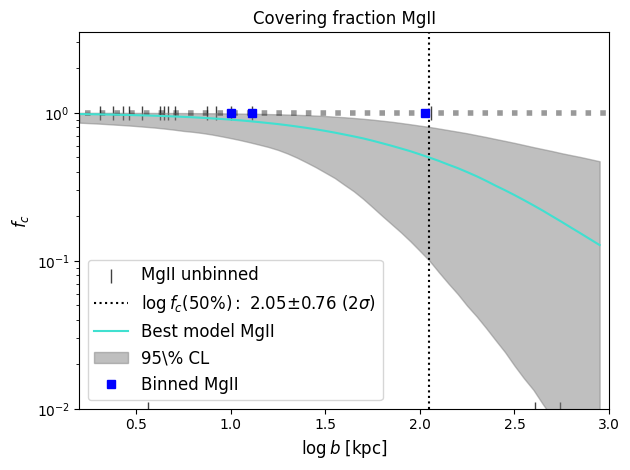

In [344]:
fc_G_01_bmin_norm = run_covering_2.mgii(run = True, filename = "fc_data/G_01_bmin_norm.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [381]:
(4.50-0.92)/2

1.79

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3380.19draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.011483 -3.922966 -2.788747 -1.891594 -1.211271 -0.727361
beta   1.886031  1.159889  1.461712  1.844976  2.335118  2.755225
alpha -1.9 [-3.92--0.73] (95\%) 
beta 1.8 [1.16-2.75] (95\%) 

WAIC 17.82 +/- 6.91 peff 1.77
WAIC deviance 14.293646017342201
LOO 18.40 +/- 7.16 peff 2.05
WBIC  22.756853203525786


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 16.7465
DIC Lmax 21.0944 2.17
Deviance best 16.7656
DIC best 21.0754 2.15
|               WAIC |                LOO |               WBIC |               DIC |
| 17.824768148228586 | 18.395612712949664 | 22.756853203525786 | 21.07535412560368 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.011483 -3.922966 -2.788747 -1.891594 -1.211271 -0.727361
beta   1.886031  1.159889  1.461712  1.844976  2.335118  2.755225


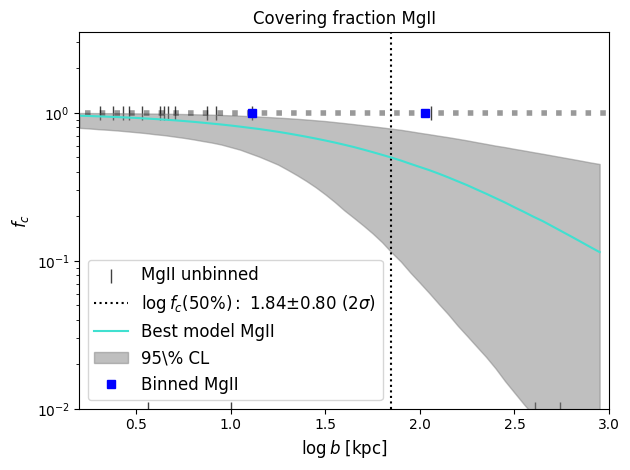

In [345]:
fc_G_03_bmin_norm = run_covering_2.mgii(run = True, filename = "fc_data/G_03_bmin_norm.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [382]:
(3.922966-0.727361)/2

1.5978025

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3300.92draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.011607 -4.185696 -2.887335 -1.867705 -1.136142 -0.631515
beta   1.698189  0.993223  1.264885  1.641430  2.151714  2.680807
alpha -1.9 [-4.19--0.63] (95\%) 
beta 1.6 [0.99-2.68] (95\%) 

WAIC 20.23 +/- 6.35 peff 1.90
WAIC deviance 16.43550215456285
LOO 20.80 +/- 6.63 peff 2.18
WBIC  23.587968551510414
Deviance Lmax 18.9793
DIC Lmax 23.2989 2.16
Deviance best 18.9862
DIC best 23.2920 2.15
|              WAIC |               LOO |               WBIC |                DIC |
| 20.23280319179031 | 20.79950030821878 | 23.587968551510414 | 23.291950895713853 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.011607 -4.185696 -2.887335 -1.867705 -1.136142 -0.631515
beta   1.698189  0.993223  1.264885  1.641430  2.151714  2.680807


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


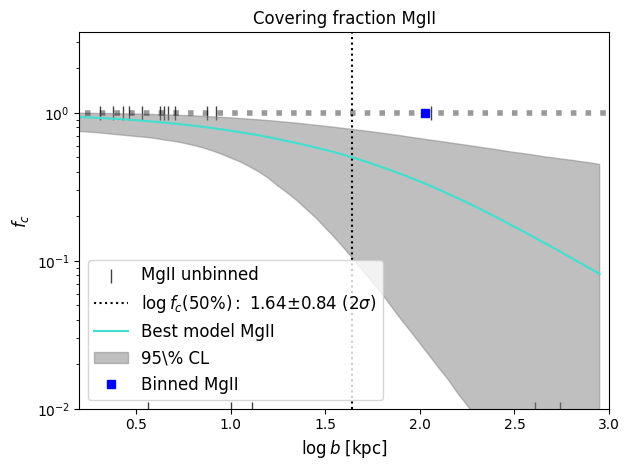

In [346]:
fc_G_05_bmin_norm = run_covering_2.mgii(run = True, filename = "fc_data/G_05_bmin_norm.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [384]:
(0.631515-4.185696)/2

-1.7770905

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3241.76draws/s]
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.020397 -6.706883 -4.442637 -2.732212 -1.607161 -0.940459
beta   1.888653  1.329979  1.549311  1.817433  2.240592  2.852487
alpha -2.7 [-6.71--0.94] (95\%) 
beta 1.8 [1.33-2.85] (95\%) 

WAIC 15.06 +/- 4.98 peff 1.57
WAIC deviance 11.922272792431894
LOO 15.25 +/- 5.06 peff 1.66
WBIC  21.854231065935796
Deviance Lmax 14.4435
DIC Lmax 18.9477 2.25
Deviance best 14.4889
DIC best 18.9023 2.21
|               WAIC |                LOO |               WBIC |               DIC |
| 15.058708930862714 | 15.250471829596496 | 21.854231065935796 | 18.90230924250225 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.020397 -6.706883 -4.442637 -2.732212 -1.607161 -0.940459
beta   1.888653  1.329979  1.549311  1.817433  2.240592  2.852487


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


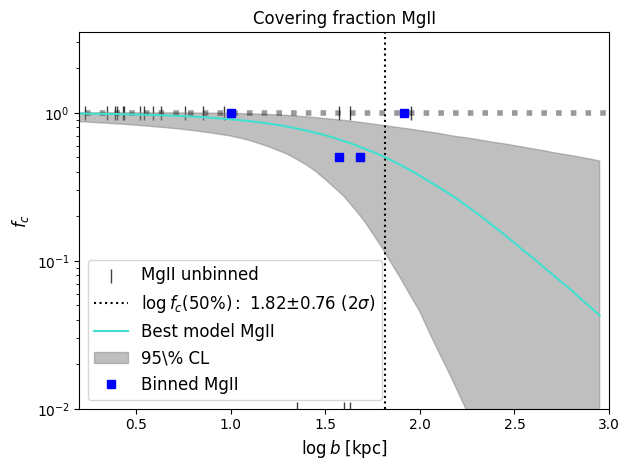

In [347]:
fc_G_01_bcenter_norm = run_covering_2.mgii(run = True, filename = "fc_data/G_01_bcenter_norm.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [385]:
0.5*(6.706883 - 0.940459)

2.8832120000000003

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3090.89draws/s]
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -4.721794 -9.524850 -6.756609 -4.439088 -2.694590 -1.523304
beta   1.561369  1.185303  1.363879  1.538959  1.747516  2.124312
alpha -4.4 [-9.53--1.52] (95\%) 
beta 1.5 [1.19-2.12] (95\%) 

WAIC 11.84 +/- 4.10 peff 1.30
WAIC deviance 9.233463865863765
LOO 11.98 +/- 4.16 peff 1.37
WBIC  20.735784126839874


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 12.1546
DIC Lmax 16.2317 2.04
Deviance best 12.1912
DIC best 16.1952 2.00
|               WAIC |                LOO |               WBIC |                DIC |
| 11.842724631055624 | 11.976157882912517 | 20.735784126839874 | 16.195204515452776 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -4.721794 -9.524850 -6.756609 -4.439088 -2.694590 -1.523304
beta   1.561369  1.185303  1.363879  1.538959  1.747516  2.124312


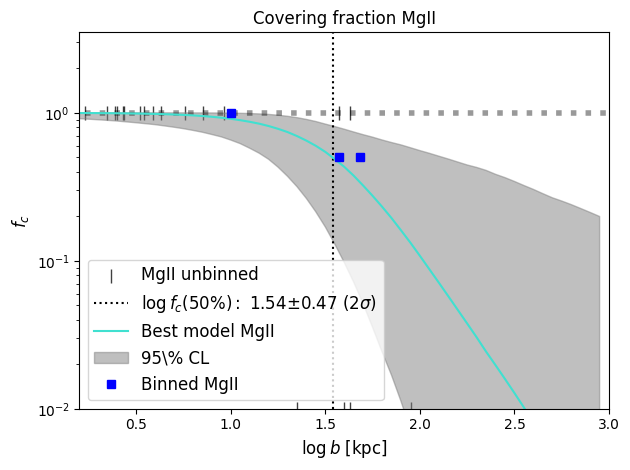

In [348]:
fc_G_03_bcenter_norm = run_covering_2.mgii(run = True, filename = "fc_data/G_03_bcenter_norm.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [386]:
0.5*(9.524850 - 1.523304)

4.000773000000001

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3435.53draws/s]
There were 59 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.238344 -6.358465 -4.582620 -3.068020 -1.883216 -1.032624
beta   1.500004  1.058646  1.242471  1.459018  1.741987  2.260006
alpha -3.1 [-6.36--1.04] (95\%) 
beta 1.5 [1.06-2.26] (95\%) 

WAIC 17.26 +/- 5.50 peff 1.71
WAIC deviance 13.849012910470218
LOO 17.50 +/- 5.64 peff 1.83
WBIC  22.647540157584636


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 16.5721
DIC Lmax 20.7098 2.07
Deviance best 16.5913
DIC best 20.6906 2.05
|               WAIC |                LOO |               WBIC |                DIC |
| 17.260268888823983 | 17.500650271605966 | 22.647540157584636 | 20.690649889556994 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.238344 -6.358465 -4.582620 -3.068020 -1.883216 -1.032624
beta   1.500004  1.058646  1.242471  1.459018  1.741987  2.260006


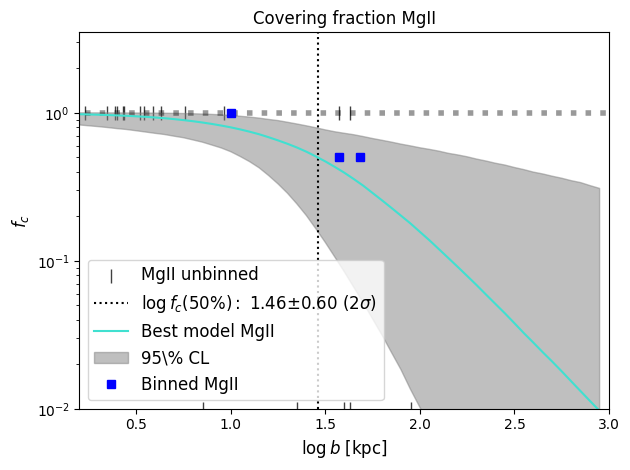

In [349]:
fc_G_05_bcenter_norm = run_covering_2.mgii(run = True, filename = "fc_data/G_05_bcenter_norm.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [387]:
0.5*(6.358465-1.032624)

2.6629205

In [356]:
logb_norm = np.linspace(0.05, 4)
# The ranges for the parameters:
logb = np.linspace(0.1, 2.5, 50)
logm = np.linspace(8, 12, 20)
logsfr = np.linspace(-3, 3, 20)
z_range = np.linspace(0.4, 1.5, 20)
logz = np.log10(1+z_range)

# The fixed values to estimates the fc:
z = 1
Z = np.log10(1+z)
m = 9
sfr = 0

# The extraction of the low, middle, high values:
pbest_G_01_bcenter, plow_G_01_bcenter, phigh_G_01_bcenter = \
    fc_G_01_bcenter_norm.predict_2d(logb_norm, params=fc_G_01_bcenter_norm.trace, z = 1)
pbest_G_03_bcenter, plow_G_03_bcenter, phigh_G_03_bcenter = \
    fc_G_03_bcenter_norm.predict_2d(logb_norm, params=fc_G_03_bcenter_norm.trace, z = 1)
pbest_G_05_bcenter, plow_G_05_bcenter, phigh_G_05_bcenter = \
    fc_G_05_bcenter_norm.predict_2d(logb_norm, params=fc_G_05_bcenter_norm.trace, z = 1)

pbest_G_01_bmin, plow_G_01_bmin, phigh_G_01_bmin = \
    fc_G_01_bmin_norm.predict_2d(logb_norm, params=fc_G_01_bmin_norm.trace, z = 1)
pbest_G_03_bmin, plow_G_03_bmin, phigh_G_03_bmin = \
    fc_G_03_bmin_norm.predict_2d(logb_norm, params=fc_G_03_bmin_norm.trace, z = 1)
pbest_G_05_bmin, plow_G_05_bmin, phigh_G_05_bmin = \
    fc_G_05_bmin_norm.predict_2d(logb_norm, params=fc_G_05_bmin_norm.trace, z = 1)

Text(0, 0.5, '$f_c$')

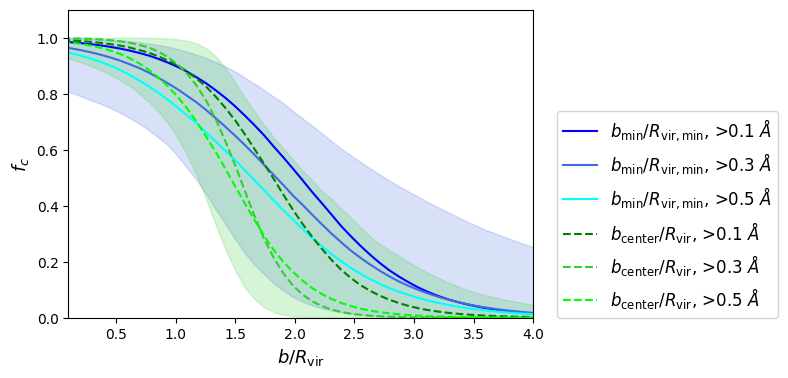

In [372]:
plt.figure(figsize = (6,4), dpi = 100)

#plt.fill_between(logb_norm, plow_G_01_bmin, phigh_G_01_bmin, color = 'blue', alpha = 0.2)
plt.plot(logb_norm, pbest_G_01_bmin, label= "$b_{\mathrm{min}}/R_{\mathrm{vir,min}}$, >0.1 $\AA$", color = "blue")

plt.fill_between(logb_norm, plow_G_03_bmin, phigh_G_03_bmin, color = 'royalblue', alpha = 0.2)
plt.plot(logb_norm, pbest_G_03_bmin, label= "$b_{\mathrm{min}}/R_{\mathrm{vir,min}}$, >0.3 $\AA$", color = "royalblue")

#plt.fill_between(logb_norm, plow_G_05_bmin, phigh_G_05_bmin, color = 'cyan', alpha = 0.2)
plt.plot(logb_norm, pbest_G_05_bmin, label= "$b_{\mathrm{min}}/R_{\mathrm{vir,min}}$, >0.5 $\AA$", color = "cyan")


#plt.fill_between(10**logb, plow_G_01_center, phigh_G_01_center, color = 'green', alpha = 0.2)
plt.plot(logb_norm, pbest_G_01_bcenter, label= "$b_{\mathrm{center}}/R_{\mathrm{vir}}$, >0.1 $\AA$", color = "green", linestyle = "--")

plt.fill_between(logb_norm, plow_G_03_bcenter, phigh_G_03_bcenter, color = 'limegreen', alpha = 0.2)
plt.plot(logb_norm, pbest_G_03_bcenter, label= "$b_{\mathrm{center}}/R_{\mathrm{vir}}$, >0.3 $\AA$", color = "limegreen", linestyle = "--")

#plt.fill_between(logb_norm, plow_G_05_bcenter, phigh_G_05_center, color = 'lime', alpha = 0.2)
plt.plot(logb_norm, pbest_G_05_bcenter, label= "$b_{\mathrm{center}}/R_{\mathrm{vir}}$, >0.5 $\AA$", color = "lime", linestyle = "--")

plt.legend(fontsize = 12, loc = (1.05, 0))
plt.ylim((0.00,1.1))
plt.xlim((0.1,4))
#plt.yscale("log")
plt.xlabel("$b/ R_{\mathrm{vir}}$", size = 13)
plt.ylabel("$f_c$", size = 13)
#plt.xscale("log")

### Fc for bmin

In [243]:
pbest_G4_9_bmin_noz, plow_G4_9_bmin_noz, phigh_G4_9_bmin_noz = \
fc_G4_9_bmin_noz.predict_2d(logb, 1.0, params=fc_G4_9_bmin_noz.trace)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Text(0, 0.5, '$f_c$')

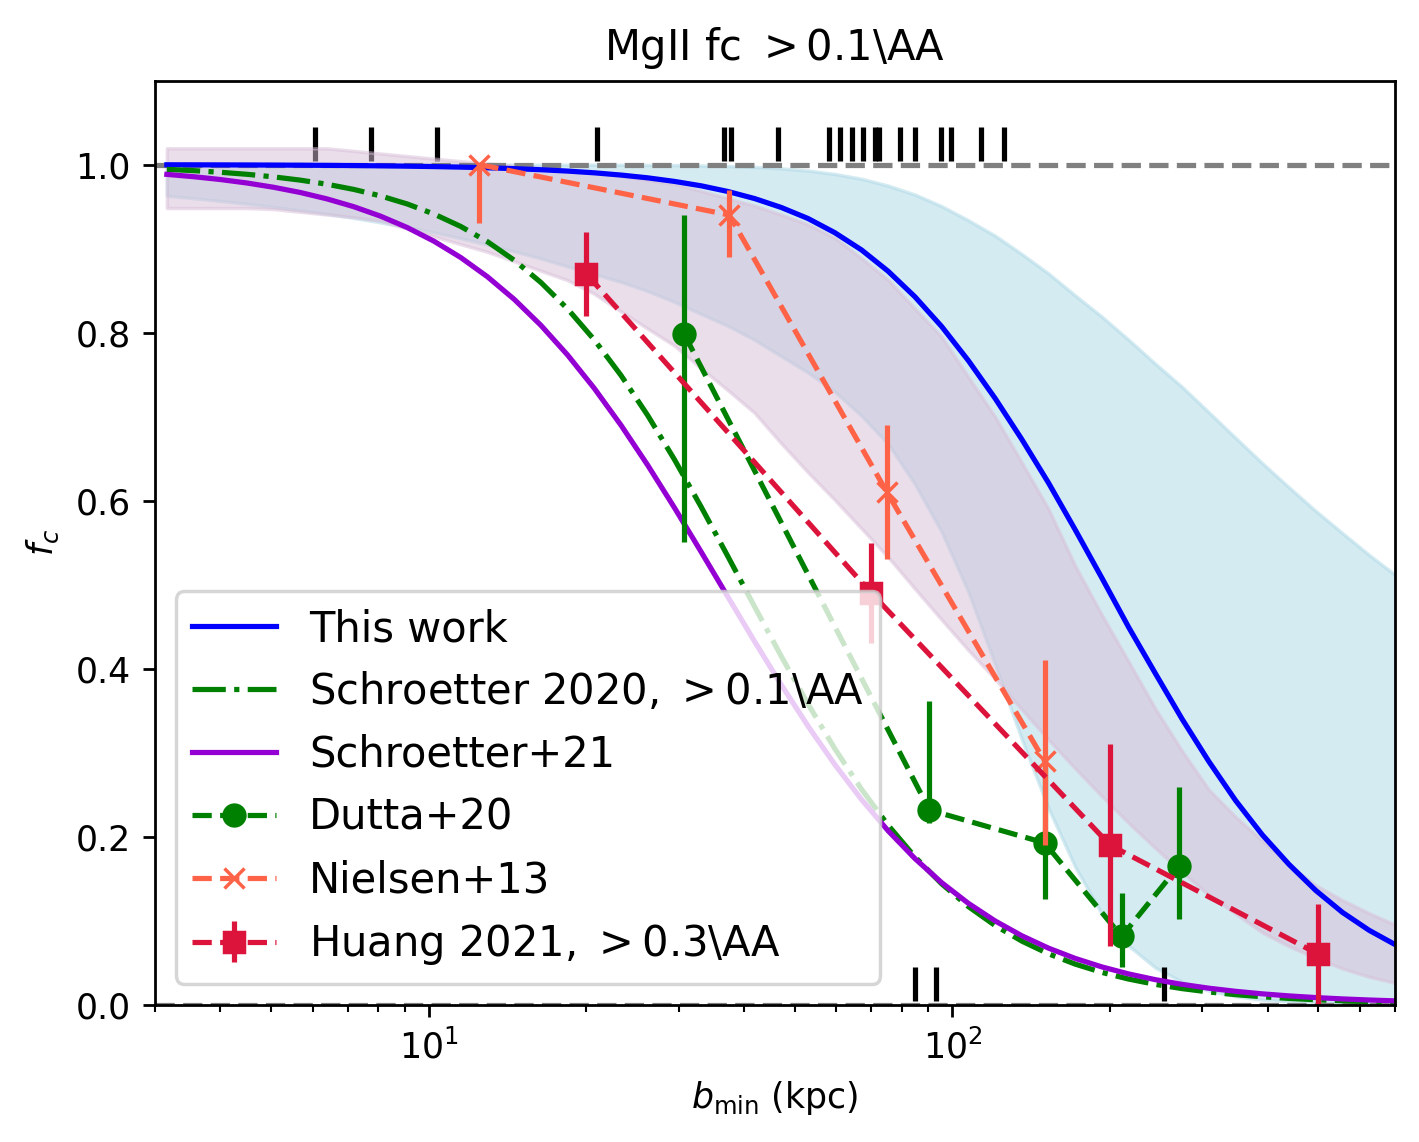

In [244]:
plt.figure(dpi = 250)
plt.rcParams['lines.linewidth']=1.5

plt.title("MgII fc $> 0.1$\AA")

plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow_G4_9_bmin_noz, phigh_G4_9_bmin_noz, color = 'lightblue', alpha = 0.5)
plt.plot(10**logb, pbest_G4_9_bmin_noz, label= "This work", color = "blue")
plt.scatter(10**fc_G4_9_bmin_noz.log_flux, fc_G4_9_bmin_noz.outcomes+0.025, marker = "|", color = "black", s = 100)
#plt.scatter(b, fc_cum)

#plt.plot(rrr, fcdiff)

#Schroetter 2020
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-", \
         color = "darkviolet", marker = " ", label = "Schroetter+21")
#plt.plot(10**Schroetter_fc_sup["log_b_sup"], 10**Schroetter_fc_sup["log_fc_sup"])
#plt.plot(10**Schroetter_fc_inf["log_b_inf"], 10**Schroetter_fc_inf["log_fc_inf"])
#plt.plot(10**logb, 10**Sc_logb_sup)
#plt.plot(10**logb, 10**Sc_logb_inf)
plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Dutta 2020
#plt.plot(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc01"], linestyle = "--", marker = "o", label = "Dutta 01")
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc03"], linestyle = "--", marker = "o", label = "Dutta 03")
plt.plot(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01"], linestyle = "--", \
            marker = "o", label = "Dutta+20", color = "green")
plt.vlines(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01_inf"], Dutta_2020_fcdiff01["fc01_sup"],\
           color = "green")

#Nielsen 2013
plt.plot(Nielsen_2013["b"], Nielsen_2013["fc01"], color = "tomato", marker = "x", \
         linestyle = '--', label = "Nielsen+13")
plt.vlines(Nielsen_2013["b"], Nielsen_2013["fc01_inf"], Nielsen_2013["fc01_sup"], color = "tomato")
#plt.scatter(Nielsen_2013["b"], Nielsen_2013["fc03"],  color = "orange", marker = "s", label = "Nielsen 2013, $> 0.3$\AA")
#plt.plot(Nielsen_2013["b"], Nielsen_2013["fc1"],  color = "skyblue", marker = "x", label = "Nielsen 2013, 1.0A")

#Huang 2021
plt.errorbar(Huang_2021["b"], Huang_2021["all"], yerr= Huang_2021["all_sigma"],\
             linestyle = '--', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3$\AA")



#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
#plt.ylim((0.05,1.5))
#plt.xlim((2, 700))
plt.ylim((0.0,1.1))
plt.xlim((3, 700))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b_{\mathrm{min}}$ (kpc)")
plt.ylabel("$f_c$")

### For b_center_kpc

In [245]:
pbest_G4_9_bcenter_noz, plow_G4_9_bcenter_noz, phigh_G4_9_bcenter_noz = \
fc_G4_9_bcenter_noz.predict_2d(logb, 1.0, params=fc_G4_9_bcenter_noz.trace)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


In [258]:
def logistic_with_z(b, A, B, C, logz):
    print("logistic with z:")
    print(A, B, C)
    t = A*(np.log10(b)- B*logz - C)
    P = 1/(1+np.exp(-t))
    print(P, logistic(A*(np.log10(b) - B*logz - C)))
    return P

def logistic_no_z(b, A, C):
    t = A*(np.log10(b) - C)
    P = 1/(1+np.exp(-t))
    return P


z = 1
logz = np.log10(1+z)
param_01A_Ilane = [-4.2, 2, 1]
param_inf_Ilane = np.array([0, -0.7-2.0, 0.2-1.0])/2
param_sup_Ilane = np.array([0, 4.3-2.0, 1.9-1.0])/2
pp_Ilane = logistic_with_z(bb, param_01A_Ilane[0], param_01A_Ilane[1], param_01A_Ilane[2], logz)




def logistic(t):
    return 1/(1+np.exp(-t))
    
def logistic_eq6(A, C, logb):
    return logistic(A*(logb - C))

def logistic_eq7(A, B, C, logb, z):
    print("logistic with z:")
    print(A, B, C)
    return logistic(A*(logb - B*np.log10(1+z) - C))

Il_6 = logistic_eq6(-4.7, 1.6, logb)
Il_7 = logistic_eq7(-4.2, 2.0, 1.0, logb, 1)
Il = np.array([logb, Il_6, Il_7])

Schroetter_2021 = pd.DataFrame(Il.T, columns = ["logb", "best_fit_b", "best_fit_bz"])

logistic with z:
-4.2 2 1
[0.99818282 0.9977687  0.99726046 0.99663685 0.99587187 0.99493378
 0.99378383 0.99237487 0.99064956 0.98853838 0.98595728 0.98280505
 0.97896031 0.97427841 0.96858808 0.9616884  0.95334618 0.9432946
 0.93123359 0.91683344 0.89974246 0.87960045 0.85605923 0.82881092
 0.79762386 0.76238407 0.72313793 0.68012934 0.63382278 0.58490394
 0.53425212 0.48288397 0.43187502 0.38227114 0.33500507 0.29083172
 0.25029073 0.21369809 0.18116255 0.15261908 0.12787055 0.10663021
 0.08855979 0.07330047 0.0604959  0.04980788 0.0409259  0.03357184
 0.02750135 0.02250297] [0.99818282 0.9977687  0.99726046 0.99663685 0.99587187 0.99493378
 0.99378383 0.99237487 0.99064956 0.98853838 0.98595728 0.98280505
 0.97896031 0.97427841 0.96858808 0.9616884  0.95334618 0.9432946
 0.93123359 0.91683344 0.89974246 0.87960045 0.85605923 0.82881092
 0.79762386 0.76238407 0.72313793 0.68012934 0.63382278 0.58490394
 0.53425212 0.48288397 0.43187502 0.38227114 0.33500507 0.29083172
 0.25029073 0.

Text(0, 0.5, '$f_c$')

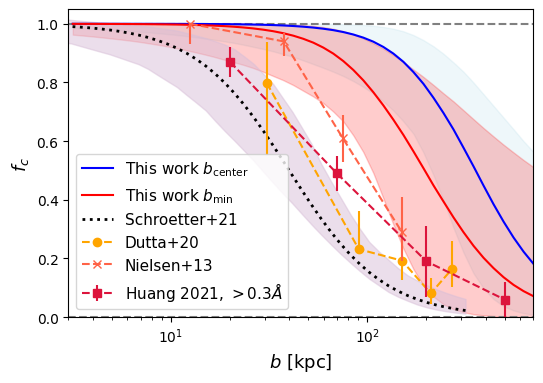

In [261]:
plt.figure(figsize = (6,4), dpi = 100)
#plt.rcParams['lines.linewidth']=1.5

#plt.title("MgII fc $> 0.1$\AA")

plt.axhline(0.0, color = "grey", linestyle = "--")
plt.axhline(1, color = "grey", linestyle = "--")
plt.fill_between(10**logb, plow_G4_9_bcenter_noz, phigh_G4_9_bcenter_noz, color = 'lightblue', alpha = 0.2)
plt.plot(10**logb, pbest_G4_9_bcenter_noz, label= "This work $b_{\mathrm{center}}$", color = "blue")
#plt.scatter(10**fc_G4_9_bcenter_noz.log_flux, fc_G4_9_bcenter_noz.outcomes+0.025, marker = "|", color = "black", s = 100)
#plt.scatter(b, fc_cum)
plt.fill_between(10**logb, plow_G4_9_bmin_noz, phigh_G4_9_bmin_noz, color = 'red', alpha = 0.2)
plt.plot(10**logb, pbest_G4_9_bmin_noz, label= "This work $b_{\mathrm{min}}$", color = "red")


#plt.plot(rrr, fcdiff)

plt.plot(bb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter+21", linewidth = 2)
plt.fill_between(bb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Schroetter 2020
#plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "dotted", \
#         color = "darkblue", marker = " ", label = "Schroetter+21")
#plt.plot(10**Schroetter_fc_sup["log_b_sup"], 10**Schroetter_fc_sup["log_fc_sup"])
#plt.plot(10**Schroetter_fc_inf["log_b_inf"], 10**Schroetter_fc_inf["log_fc_inf"])
#plt.plot(10**logb, 10**Sc_logb_sup)
#plt.plot(10**logb, 10**Sc_logb_inf)
#plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Dutta 2020
#plt.plot(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups"], linestyle = "--", color = "orange", marker = "o", label = "Dutta 2020 groups")
#plt.vlines(Dutta_2020["R(kpc)"], Dutta_2020["fc_groups_inf"], Dutta_2020["fc_groups_sup"], color = "orange", lw=1)
#plt.plot(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol"], linestyle = "--",  color = "red", marker = "o", label = "Dutta 2020 isolated")
#plt.vlines(np.log10(Dutta_2020["R(kpc)"]), Dutta_2020["fc_isol_inf"], Dutta_2020["fc_isol_sup"], color = "red", lw=1)
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc01"], linestyle = "--", marker = "o", label = "Dutta 01")
#plt.plot(Dutta_2020_fcdiff["R(kpc)"], Dutta_2020_fcdiff["fc03"], linestyle = "--", marker = "o", label = "Dutta 03")
plt.plot(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01"], linestyle = "--", \
            marker = "o", label = "Dutta+20", color = "orange")
plt.vlines(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01_inf"], Dutta_2020_fcdiff01["fc01_sup"],\
           color = "orange")

#Nielsen 2013
plt.plot(Nielsen_2013["b"], Nielsen_2013["fc01"], color = "tomato", marker = "x", \
         linestyle = '--', label = "Nielsen+13")
plt.vlines(Nielsen_2013["b"], Nielsen_2013["fc01_inf"], Nielsen_2013["fc01_sup"], color = "tomato")

plt.errorbar(Huang_2021["b"], Huang_2021["all"], yerr= Huang_2021["all_sigma"],\
             linestyle = '--', color = "crimson", marker = "s", label = "Huang 2021, $> 0.3 \AA$")




#plt.legend(bbox_to_anchor=(0.5, 1.12), loc = 'center', ncol = 2)
#plt.legend(fontsize = 12, loc = (0.1,-0.8))
plt.legend(fontsize = 11)
#plt.ylim((0.05,1.5))
#plt.xlim((2, 700))
plt.ylim((0.0,1.05))
plt.xlim((3, 700))
plt.xscale("log")
#plt.yscale("log")
plt.xlabel("$b$ [kpc]", size = 13)
plt.ylabel("$f_c$", size = 13)

# With different thresholds

## For bmin

In [262]:
G4_9_bmin_lin = G4_9[["b_min_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2", "REW_2796"]]
G4_9_bmin_lin = G4_9_bmin_lin.rename(columns = {"b_min_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G4_9_bmin_log = G4_9_bmin_lin.copy()
G4_9_bmin_log["log10(b)"] = np.log10(G4_9_bmin_lin["b"])

In [263]:
G_01 = G4_9_bmin_log.copy()
G_03 = G4_9_bmin_log.copy()
G_05 = G4_9_bmin_log.copy()
G_08 = G4_9_bmin_log.copy()
G_1 = G4_9_bmin_log.copy()
G_15 = G4_9_bmin_log.copy()



G_01["detection"] = G_01["REW_2796"]>= 0.1
G_03["detection"] = G_03["REW_2796"]>= 0.3
G_05["detection"] = G_05["REW_2796"]>= 0.5
G_08["detection"] = G_08["REW_2796"]>= 0.8
G_1["detection"] = G_1["REW_2796"]>= 1
G_15["detection"] = G_15["REW_2796"]>= 1.5

G_01["detection"] = G_01["detection"].astype(int)
G_03["detection"] = G_03["detection"].astype(int)
G_05["detection"] = G_05["detection"].astype(int)
G_08["detection"] = G_08["detection"].astype(int)
G_1["detection"] = G_1["detection"].astype(int)
G_15["detection"] = G_15["detection"].astype(int)

G_01_save = G_01[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_03_save = G_03[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_05_save = G_05[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_08_save = G_08[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_1_save = G_1[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_15_save = G_15[["group_id", "log10(b)","detection", "z_gal", "mass"]]

G_01_save.to_csv("fc_data/G_01.csv", index = False)
G_03_save.to_csv("fc_data/G_03.csv", index = False)
G_05_save.to_csv("fc_data/G_05.csv", index = False)
G_08_save.to_csv("fc_data/G_08.csv", index = False)
G_1_save.to_csv("fc_data/G_1.csv", index = False)
G_15_save.to_csv("fc_data/G_15.csv", index = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:05<00:00, 1667.60draws/s]
The acceptance probability does not match the target. It is 0.9015618713822856, but should be close to 0.8. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.269822 -11.313745 -7.834442 -4.829264 -2.784509 -1.599734
beta   2.321532   2.014354  2.118412  2.274129  2.542116  2.863152
alpha -4.8 [-11.31--1.60] (95\%) 
beta 2.3 [2.01-2.86] (95\%) 

WAIC 14.80 +/- 5.24 peff 1.10
WAIC deviance 12.608710802643772
LOO 14.87 +/- 5.28 peff 1.13
WBIC  22.61004632819578


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 16.3500
DIC Lmax 20.7414 2.20
Deviance best 16.4054
DIC best 20.6861 2.14
|              WAIC |                LOO |              WBIC |                DIC |
| 14.80319805853123 | 14.866504159762485 | 22.61004632819578 | 20.686092806201955 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.269822 -11.313745 -7.834442 -4.829264 -2.784509 -1.599734
beta   2.321532   2.014354  2.118412  2.274129  2.542116  2.863152


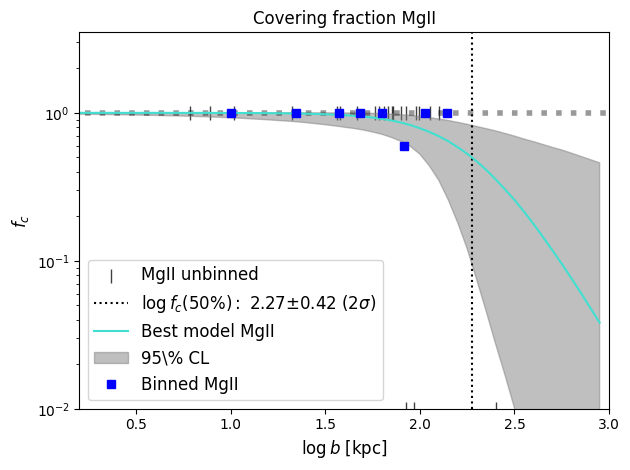

In [264]:
fc_G_01 = run_covering_2.mgii(run = True, filename = "fc_data/G_01.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [388]:
0.5*(-11.313745+1.599734)

-4.8570055000000005

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 1898.71draws/s]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.751237 -12.909680 -8.664041 -5.333957 -2.728609 -1.373077
beta   2.238276   1.953778  2.046559  2.178437  2.445548  2.844343
alpha -5.3 [-12.91--1.38] (95\%) 
beta 2.2 [1.95-2.84] (95\%) 

WAIC 15.87 +/- 4.50 peff 1.12
WAIC deviance 13.625985463034661
LOO 15.90 +/- 4.51 peff 1.14
WBIC  23.055024316464714
Deviance Lmax 17.2223
DIC Lmax 22.1723 2.47
Deviance best 17.3591
DIC best 22.0355 2.34
|               WAIC |                LOO |               WBIC |               DIC |
| 15.865207919261408 | 15.900284577184511 | 23.055024316464714 | 22.03550855630558 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.751237 -12.909680 -8.664041 -5.333957 -2.728609 -1.373077
beta   2.238276   1.953778  2.046559  2.178437  2.445548  2.844343


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


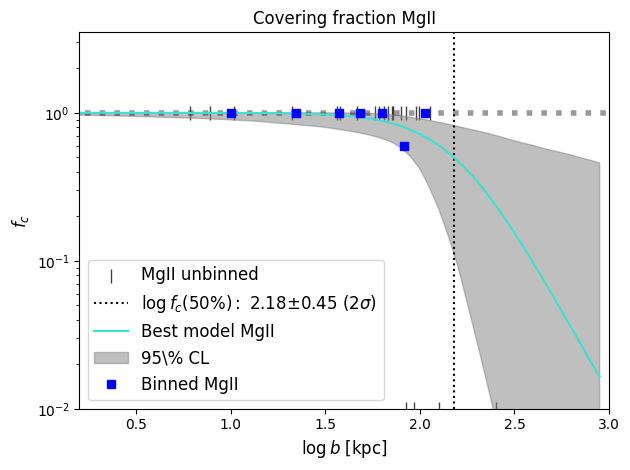

In [265]:
fc_G_03 = run_covering_2.mgii(run = True, filename = "fc_data/G_03.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [389]:
0.5*(12.909680-1.373077)

5.7683015

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 1854.67draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -6.912036 -13.798674 -9.988266 -6.624686 -3.840143 -1.914913
beta   2.099338   1.907340  1.982232  2.072434  2.215733  2.461197
alpha -6.6 [-13.80--1.92] (95\%) 
beta 2.1 [1.91-2.46] (95\%) 

WAIC 15.31 +/- 3.56 peff 0.88
WAIC deviance 13.542346464860291
LOO 15.32 +/- 3.57 peff 0.89
WBIC  23.045932420783963
Deviance Lmax 17.6429
DIC Lmax 21.7038 2.03
Deviance best 17.6895
DIC best 21.6571 1.98
|               WAIC |                LOO |               WBIC |                DIC |
| 15.307698185369686 | 15.323341585779342 | 23.045932420783963 | 21.657123568376914 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -6.912036 -13.798674 -9.988266 -6.624686 -3.840143 -1.914913
beta   2.099338   1.907340  1.982232  2.072434  2.215733  2.461197


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


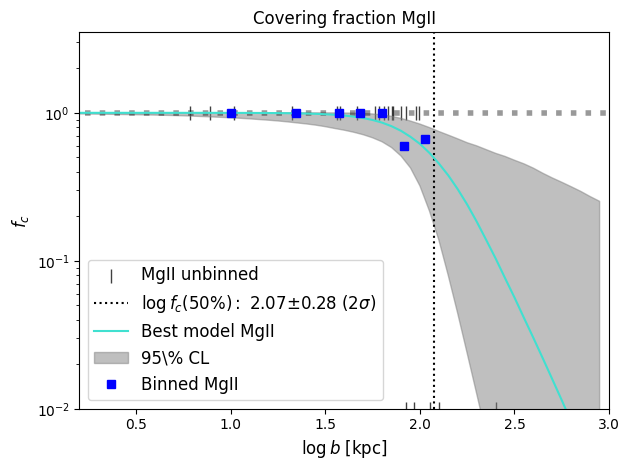

In [266]:
fc_G_05 = run_covering_2.mgii(run = True, filename = "fc_data/G_05.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [390]:
0.5*(13.798674 - 1.914913)

5.9418805

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 2018.40draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.303852 -4.393620 -2.506658 -1.100541 -0.138872  0.620277
beta   1.865539  0.798766  1.532464  1.861027  2.265288  2.786271
alpha -1.1 [-4.39-0.62] (95\%) 
beta 1.9 [0.80-2.79] (95\%) 

WAIC 31.82 +/- 2.76 peff 1.70
WAIC deviance 28.422138198310343
LOO 31.93 +/- 2.84 peff 1.75
WBIC  27.267645389420707
Deviance Lmax 30.7846
DIC Lmax 35.3942 2.30
Deviance best 31.0349
DIC best 35.1438 2.05
|              WAIC |                LOO |               WBIC |             DIC |
| 31.81560268125152 | 31.925439780532542 | 27.267645389420707 | 35.143848870266 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.303852 -4.393620 -2.506658 -1.100541 -0.138872  0.620277
beta   1.865539  0.798766  1.532464  1.861027  2.265288  2.786271


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


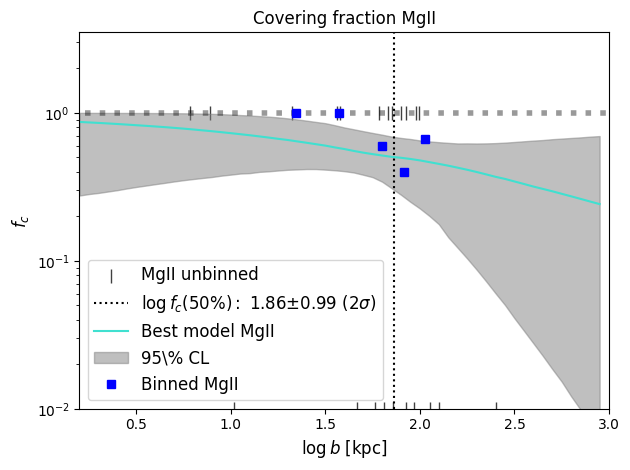

In [267]:
fc_G_08 = run_covering_2.mgii(run = True, filename = "fc_data/G_08.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 1961.85draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.266545 -4.527290 -2.441790 -1.027062 -0.124615  0.684743
beta   1.656855  0.477598  1.247122  1.662242  2.078341  2.694272
alpha -1.0 [-4.53-0.68] (95\%) 
beta 1.7 [0.48-2.69] (95\%) 

WAIC 32.03 +/- 2.46 peff 1.78
WAIC deviance 28.465710953512673
LOO 32.30 +/- 2.62 peff 1.92
WBIC  27.3152066488805
Deviance Lmax 30.7096
DIC Lmax 35.8267 2.56
Deviance best 31.0700
DIC best 35.4662 2.20
|              WAIC |                LOO |             WBIC |              DIC |
| 32.03462523739791 | 32.303956752204684 | 27.3152066488805 | 35.4662246328316 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -1.266545 -4.527290 -2.441790 -1.027062 -0.124615  0.684743
beta   1.656855  0.477598  1.247122  1.662242  2.078341  2.694272


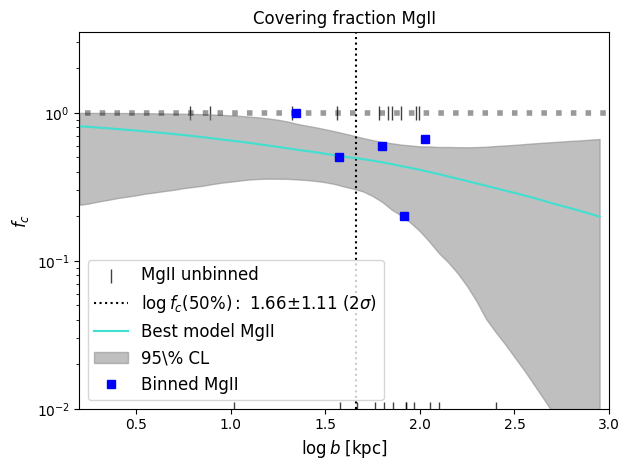

In [268]:
fc_G_1 = run_covering_2.mgii(run = True, filename = "fc_data/G_1.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:04<00:00, 2004.25draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.893869 -7.437631 -5.480189 -3.726135 -2.316404 -1.232963
beta   1.270259  0.705160  1.063488  1.302021  1.481434  1.619453
alpha -3.7 [-7.44--1.24] (95\%) 
beta 1.3 [0.71-1.62] (95\%) 

WAIC 19.45 +/- 6.14 peff 1.84
WAIC deviance 15.764218351620077
LOO 19.68 +/- 6.25 peff 1.96
WBIC  23.599492839135376
Deviance Lmax 19.0783
DIC Lmax 23.2637 2.09
Deviance best 19.0914
DIC best 23.2506 2.08
|               WAIC |                LOO |               WBIC |                DIC |
| 19.452875318673694 | 19.675347229340783 | 23.599492839135376 | 23.250615716600876 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.893869 -7.437631 -5.480189 -3.726135 -2.316404 -1.232963
beta   1.270259  0.705160  1.063488  1.302021  1.481434  1.619453


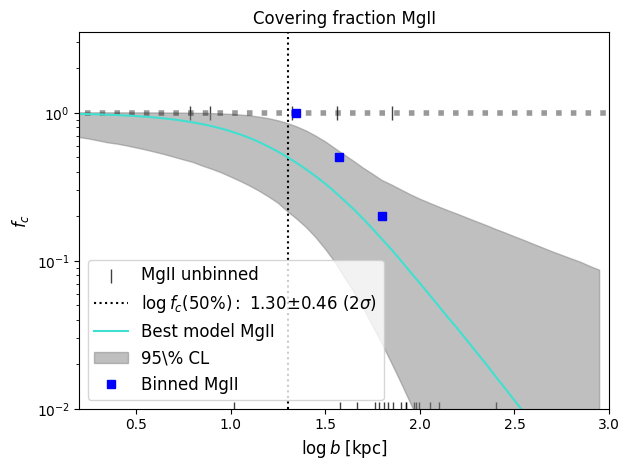

In [269]:
fc_G_15 = run_covering_2.mgii(run = True, filename = "fc_data/G_15.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [271]:
# The ranges for the parameters:
logb = np.linspace(0.1, 2.5, 50)
logm = np.linspace(8, 12, 20)
logsfr = np.linspace(-3, 3, 20)
z_range = np.linspace(0.4, 1.5, 20)
logz = np.log10(1+z_range)

# The fixed values to estimates the fc:
z = 1
Z = np.log10(1+z)
m = 9
sfr = 0

# The extraction of the low, middle, high values:
pbest_G_01, plow_G_01, phigh_G_01 = \
    fc_G_01.predict_2d(logb, params=fc_G_01.trace, z = 1)
pbest_G_03, plow_G_03, phigh_G_03 = \
    fc_G_03.predict_2d(logb, params=fc_G_03.trace, z = 1)
pbest_G_05, plow_G_05, phigh_G_05 = \
    fc_G_05.predict_2d(logb, params=fc_G_05.trace, z = 1)
pbest_G_08, plow_G_08, phigh_G_08 = \
    fc_G_08.predict_2d(logb, params=fc_G_08.trace, z = 1)
pbest_G_1, plow_G_1, phigh_G_1 = \
    fc_G_1.predict_2d(logb, params=fc_G_1.trace, z = 1)
pbest_G_15, plow_G_15, phigh_G_15 = \
    fc_G_15.predict_2d(logb, params=fc_G_15.trace, z = 1)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Text(0, 0.5, '$f_c$')

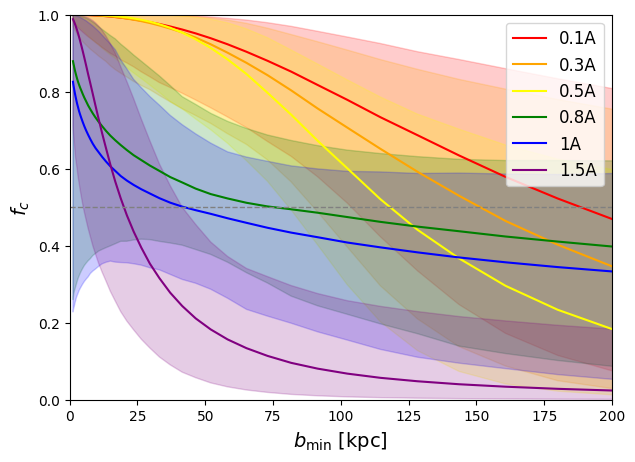

In [272]:
plt.figure(figsize = (7,5), dpi = 100)

#plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")

plt.fill_between(10**logb, plow_G_01, phigh_G_01, color = 'red', alpha = 0.2)
plt.plot(10**logb, pbest_G_01, label= "0.1A", color = "red")

plt.fill_between(10**logb, plow_G_03, phigh_G_03, color = 'orange', alpha = 0.2)
plt.plot(10**logb, pbest_G_03, label= "0.3A", color = "orange")

plt.fill_between(10**logb, plow_G_05, phigh_G_05, color = 'yellow', alpha = 0.2)
plt.plot(10**logb, pbest_G_05, label= "0.5A", color = "yellow")

plt.fill_between(10**logb, plow_G_08, phigh_G_08, color = 'green', alpha = 0.2)
plt.plot(10**logb, pbest_G_08, label= "0.8A", color = "green")

plt.fill_between(10**logb, plow_G_1, phigh_G_1, color = 'blue', alpha = 0.2)
plt.plot(10**logb, pbest_G_1, label= "1A", color = "blue")

plt.fill_between(10**logb, plow_G_15, phigh_G_15, color = 'purple', alpha = 0.2)
plt.plot(10**logb, pbest_G_15, label= "1.5A", color = "purple")

#plt.fill_between(10**logb, plow_isol_2_z_mass_SFR, phigh_isol_2_z_mass_SFR, color = 'deeppink', alpha = 0.2)
#plt.plot(10**logb, pbest_isol_2_z_mass_SFR, label= "2A", color = "deeppink")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter 2021")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.0,1.))
plt.xlim((0,200))
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")


plt.xlabel("$b_{\mathrm{min}}$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

## For bcenter

In [296]:
G4_9_bcenter_lin = G4_9[["b_center_kpc", "group_id", "center_z", "bool_abs_01", "Mvir_sigma2", "REW_2796"]]
G4_9_bcenter_lin = G4_9_bcenter_lin.rename(columns = {"b_center_kpc": "b", "bool_abs_01":"detection", "center_z": "z_gal", "Mvir_sigma2": "mass"})

G4_9_bcenter_log = G4_9_bcenter_lin.copy()
G4_9_bcenter_log["log10(b)"] = np.log10(G4_9_bcenter_lin["b"])

In [297]:
G_01 = G4_9_bcenter_log.copy()
G_03 = G4_9_bcenter_log.copy()
G_05 = G4_9_bcenter_log.copy()
G_08 = G4_9_bcenter_log.copy()
G_1 = G4_9_bcenter_log.copy()
G_15 = G4_9_bcenter_log.copy()



G_01["detection"] = G_01["REW_2796"]>= 0.1
G_03["detection"] = G_03["REW_2796"]>= 0.3
G_05["detection"] = G_05["REW_2796"]>= 0.5
G_08["detection"] = G_08["REW_2796"]>= 0.8
G_1["detection"] = G_1["REW_2796"]>= 1
G_15["detection"] = G_15["REW_2796"]>= 1.5

G_01["detection"] = G_01["detection"].astype(int)
G_03["detection"] = G_03["detection"].astype(int)
G_05["detection"] = G_05["detection"].astype(int)
G_08["detection"] = G_08["detection"].astype(int)
G_1["detection"] = G_1["detection"].astype(int)
G_15["detection"] = G_15["detection"].astype(int)

G_01_save = G_01[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_03_save = G_03[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_05_save = G_05[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_08_save = G_08[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_1_save = G_1[["group_id", "log10(b)","detection", "z_gal", "mass"]]
G_15_save = G_15[["group_id", "log10(b)","detection", "z_gal", "mass"]]

G_01_save.to_csv("fc_data/G_01_center.csv", index = False)
G_03_save.to_csv("fc_data/G_03_center.csv", index = False)
G_05_save.to_csv("fc_data/G_05_center.csv", index = False)
G_08_save.to_csv("fc_data/G_08_center.csv", index = False)
G_1_save.to_csv("fc_data/G_1_center.csv", index = False)
G_15_save.to_csv("fc_data/G_15_center.csv", index = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2665.62draws/s]
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5503833451938263, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.842876 -10.273292 -7.510547 -4.761984 -2.575551  1.528189
beta   2.491176   0.853112  2.401355  2.555961  2.771567  2.954976
alpha -4.8 [-10.27-1.52] (95\%) 
beta 2.6 [0.85-2.95] (95\%) 

WAIC 16.10 +/- 4.97 peff 1.26
WAIC deviance 13.59028323630291
LOO 16.28 +/- 5.01 peff 1.34
WBIC  23.41358180849247


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Deviance Lmax 18.0524
DIC Lmax 23.2671 2.61
Deviance best 18.1846
DIC best 23.1349 2.48
|              WAIC |                LOO |              WBIC |                DIC |
| 16.10471333223687 | 16.275523985346418 | 23.41358180849247 | 23.134851375851017 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.842876 -10.273292 -7.510547 -4.761984 -2.575551  1.528189
beta   2.491176   0.853112  2.401355  2.555961  2.771567  2.954976


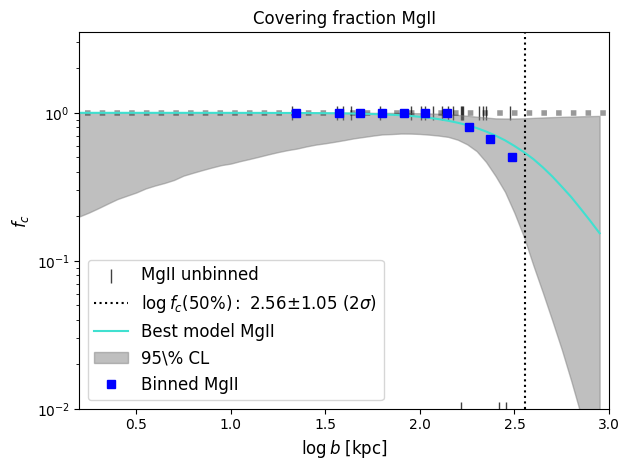

In [298]:
fc_G_01_center = run_covering_2.mgii(run = True, filename = "fc_data/G_01_center.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [391]:
0.5*(10.273292+1.528189)

5.9007404999999995

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3058.92draws/s]
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6417054420014111, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.664689 -12.669630 -8.413956 -5.195758 -2.940196 -1.625142
beta   2.517481   2.274775  2.365359  2.481994  2.684109  2.936701
alpha -5.2 [-12.67--1.63] (95\%) 
beta 2.5 [2.27-2.94] (95\%) 

WAIC 17.65 +/- 4.50 peff 1.18
WAIC deviance 15.296756370769634
LOO 17.70 +/- 4.52 peff 1.20
WBIC  23.99872508333609
Deviance Lmax 19.8633
DIC Lmax 24.7322 2.43
Deviance best 19.9540
DIC best 24.6416 2.34
|               WAIC |               LOO |              WBIC |                DIC |
| 17.652260625653867 | 17.69779829365956 | 23.99872508333609 | 24.641555107721345 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -5.664689 -12.669630 -8.413956 -5.195758 -2.940196 -1.625142
beta   2.517481   2.274775  2.365359  2.481994  2.684109  2.936701


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


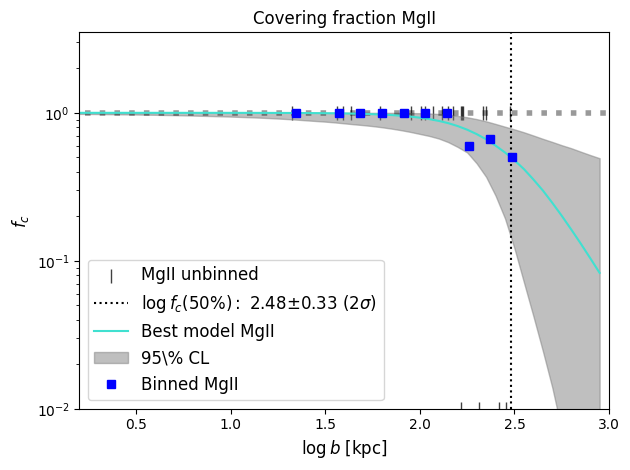

In [299]:
fc_G_03_center = run_covering_2.mgii(run = True, filename = "fc_data/G_03_center.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [392]:
0.5*(12.669630 - 1.625142)

5.522244

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3031.10draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8893480065897807, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.742296 -10.439495 -7.163129 -4.371434 -2.381349 -1.107482
beta   2.475232   2.200824  2.320255  2.443399  2.657878  2.917865
alpha -4.4 [-10.44--1.12] (95\%) 
beta 2.4 [2.20-2.92] (95\%) 

WAIC 20.97 +/- 4.30 peff 1.24
WAIC deviance 18.49002306781636
LOO 21.00 +/- 4.31 peff 1.26
WBIC  24.867281818222033
Deviance Lmax 22.5108
DIC Lmax 27.2649 2.38
Deviance best 22.6100
DIC best 27.1657 2.28
|               WAIC |                LOO |               WBIC |               DIC |
| 20.965279449236263 | 21.000953475452015 | 24.867281818222033 | 27.16570335973724 |
['alpha', 'beta']
           mean        2.5      16.0      50.0      84.0      97.5
alpha -4.742296 -10.439495 -7.163129 -4.371434 -2.381349 -1.107482
beta   2.475232   2.200824  2.320255  2.443399  2.657878  2.917865


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


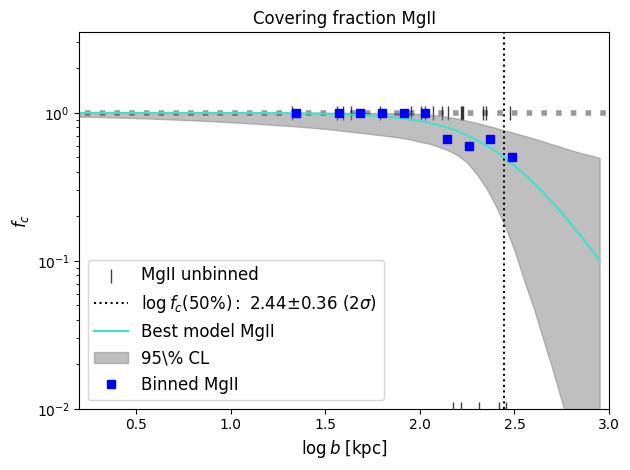

In [300]:
fc_G_05_center = run_covering_2.mgii(run = True, filename = "fc_data/G_05_center.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [393]:
0.5*(10.439495 - 1.107482)

4.6660065

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2702.75draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.441836 -6.170494 -4.203883 -2.288795 -0.685066  0.415502
beta   2.136163  1.405676  1.921817  2.152715  2.372828  2.706137
alpha -2.3 [-6.17-0.41] (95\%) 
beta 2.2 [1.41-2.70] (95\%) 

WAIC 29.81 +/- 2.68 peff 1.55
WAIC deviance 26.707650140695506
LOO 29.86 +/- 2.70 peff 1.58
WBIC  26.85630351250647
Deviance Lmax 29.2462
DIC Lmax 33.8951 2.32
Deviance best 29.4607
DIC best 33.6807 2.11
|               WAIC |               LOO |              WBIC |              DIC |
| 29.806066070133664 | 29.86365106461305 | 26.85630351250647 | 33.6806539552601 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -2.441836 -6.170494 -4.203883 -2.288795 -0.685066  0.415502
beta   2.136163  1.405676  1.921817  2.152715  2.372828  2.706137


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


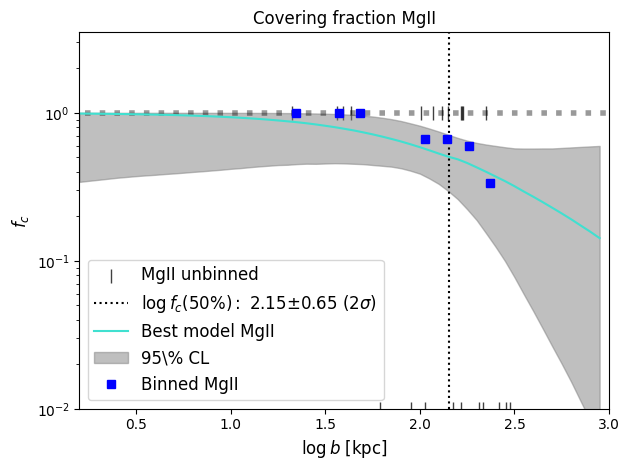

In [301]:
fc_G_08_center = run_covering_2.mgii(run = True, filename = "fc_data/G_08_center.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3208.01draws/s]
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0     50.0      84.0      97.5
alpha -1.469886 -4.649228 -2.844299 -1.27500 -0.166452  0.732919
beta   1.943492  0.945430  1.598313  1.97806  2.275274  2.792411
alpha -1.3 [-4.65-0.73] (95\%) 
beta 2.0 [0.95-2.79] (95\%) 

WAIC 31.44 +/- 2.08 peff 1.48
WAIC deviance 28.485818982446
LOO 31.51 +/- 2.11 peff 1.51
WBIC  27.253180300505598
Deviance Lmax 30.8233
DIC Lmax 35.2470 2.21
Deviance best 31.1290
DIC best 34.9413 1.91
|               WAIC |                LOO |               WBIC |               DIC |
| 31.439416623839286 | 31.506206057415195 | 27.253180300505598 | 34.94131074140396 |
['alpha', 'beta']
           mean       2.5      16.0     50.0      84.0      97.5
alpha -1.469886 -4.649228 -2.844299 -1.27500 -0.166452  0.732919
beta   1.943492  0.945430  1.598313  1.97806  2.275274  2.792411


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


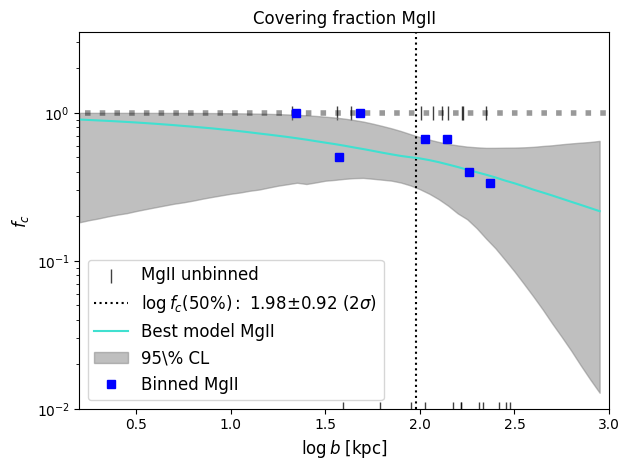

In [302]:
fc_G_1_center = run_covering_2.mgii(run = True, filename = "fc_data/G_1_center.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

MgII_closest_only
Reading from None
LEN (Outcomes) 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3057.90draws/s]
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.656147 -7.670185 -5.390035 -3.470833 -1.881391 -0.847435
beta   1.568402  0.674352  1.349333  1.639626  1.812875  1.940921
alpha -3.5 [-7.67--0.85] (95\%) 
beta 1.6 [0.67-1.94] (95\%) 

WAIC 21.68 +/- 6.50 peff 1.87
WAIC deviance 17.94340068753939
LOO 21.89 +/- 6.65 peff 1.97
WBIC  24.25947366688002
Deviance Lmax 20.8675
DIC Lmax 25.2429 2.19
Deviance best 20.8929
DIC best 25.2174 2.16
|               WAIC |               LOO |              WBIC |                DIC |
| 21.678548227978535 | 21.89322401031022 | 24.25947366688002 | 25.217422997222677 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.656147 -7.670185 -5.390035 -3.470833 -1.881391 -0.847435
beta   1.568402  0.674352  1.349333  1.639626  1.812875  1.940921


INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


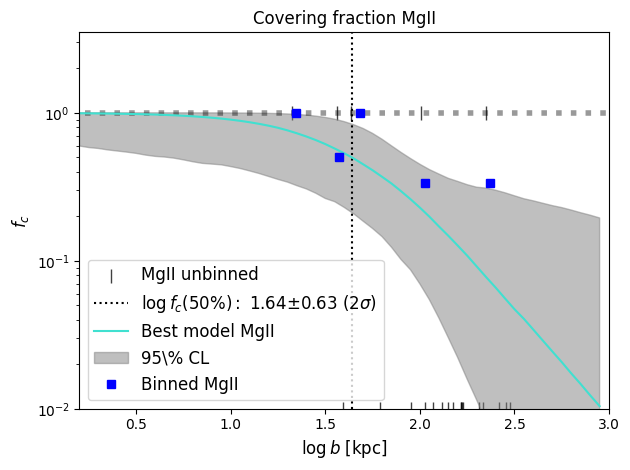

In [303]:
fc_G_15_center = run_covering_2.mgii(run = True, filename = "fc_data/G_15_center.csv", \
                            with_outliers= "",redshift = False, mass = False, errorbar = False)

In [304]:
# The ranges for the parameters:
logb = np.linspace(0.1, 2.5, 50)
logm = np.linspace(8, 12, 20)
logsfr = np.linspace(-3, 3, 20)
z_range = np.linspace(0.4, 1.5, 20)
logz = np.log10(1+z_range)

# The fixed values to estimates the fc:
z = 1
Z = np.log10(1+z)
m = 9
sfr = 0

# The extraction of the low, middle, high values:
pbest_G_01_center, plow_G_01_center, phigh_G_01_center = \
    fc_G_01_center.predict_2d(logb, params=fc_G_01_center.trace, z = 1)
pbest_G_03_center, plow_G_03_center, phigh_G_03_center = \
    fc_G_03_center.predict_2d(logb, params=fc_G_03_center.trace, z = 1)
pbest_G_05_center, plow_G_05_center, phigh_G_05_center = \
    fc_G_05_center.predict_2d(logb, params=fc_G_05_center.trace, z = 1)
pbest_G_08_center, plow_G_08_center, phigh_G_08_center = \
    fc_G_08_center.predict_2d(logb, params=fc_G_08_center.trace, z = 1)
pbest_G_1_center, plow_G_1_center, phigh_G_1_center = \
    fc_G_1_center.predict_2d(logb, params=fc_G_1_center.trace, z = 1)
pbest_G_15_center, plow_G_15_center, phigh_G_15_center = \
    fc_G_15_center.predict_2d(logb, params=fc_G_15_center.trace, z = 1)

INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /home/mcherrey/.theano/compiledir_Linux-5.4--generic-x86_64-with-glibc2.10-x86_64-3.8.8-64/lock_dir/lock


Text(0, 0.5, '$f_c$')

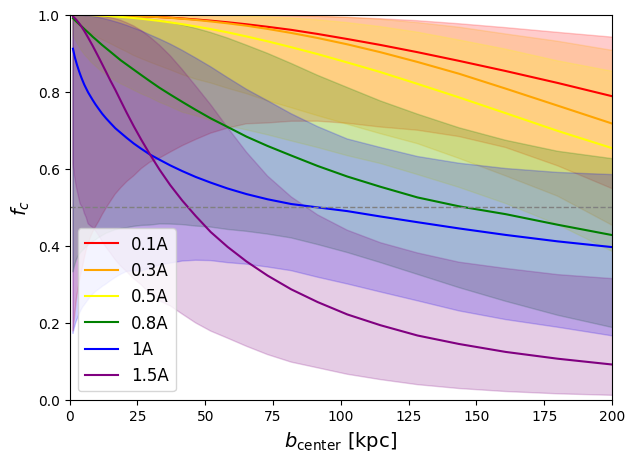

In [306]:
plt.figure(figsize = (7,5), dpi = 100)

#plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")

plt.fill_between(10**logb, plow_G_01_center, phigh_G_01_center, color = 'red', alpha = 0.2)
plt.plot(10**logb, pbest_G_01_center, label= "0.1A", color = "red")

plt.fill_between(10**logb, plow_G_03_center, phigh_G_03_center, color = 'orange', alpha = 0.2)
plt.plot(10**logb, pbest_G_03_center, label= "0.3A", color = "orange")

plt.fill_between(10**logb, plow_G_05_center, phigh_G_05_center, color = 'yellow', alpha = 0.2)
plt.plot(10**logb, pbest_G_05_center, label= "0.5A", color = "yellow")

plt.fill_between(10**logb, plow_G_08_center, phigh_G_08_center, color = 'green', alpha = 0.2)
plt.plot(10**logb, pbest_G_08_center, label= "0.8A", color = "green")

plt.fill_between(10**logb, plow_G_1_center, phigh_G_1_center, color = 'blue', alpha = 0.2)
plt.plot(10**logb, pbest_G_1_center, label= "1A", color = "blue")

plt.fill_between(10**logb, plow_G_15_center, phigh_G_15_center, color = 'purple', alpha = 0.2)
plt.plot(10**logb, pbest_G_15_center, label= "1.5A", color = "purple")

#plt.fill_between(10**logb, plow_isol_2_z_mass_SFR, phigh_isol_2_z_mass_SFR, color = 'deeppink', alpha = 0.2)
#plt.plot(10**logb, pbest_isol_2_z_mass_SFR, label= "2A", color = "deeppink")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter 2021")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.0,1.))
plt.xlim((0,200))
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")


plt.xlabel("$b_{\mathrm{center}}$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

### Recap plot for bmin and bcenter:

Text(0, 0.5, '$f_c$')

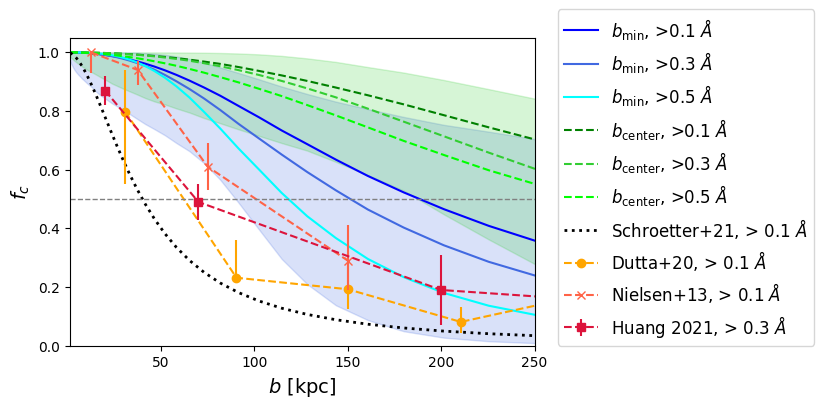

In [376]:
plt.figure(figsize = (6,4), dpi = 100)

#plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")
#plt.fill_between(10**logb, plow_G_01, phigh_G_01, color = 'blue', alpha = 0.2)
plt.plot(10**logb, pbest_G_01, label= "$b_{\mathrm{min}}$, >0.1 $\AA$", color = "blue")

plt.fill_between(10**logb, plow_G_03, phigh_G_03, color = 'royalblue', alpha = 0.2)
plt.plot(10**logb, pbest_G_03, label= "$b_{\mathrm{min}}$, >0.3 $\AA$", color = "royalblue")

#plt.fill_between(10**logb, plow_G_05, phigh_G_05, color = 'cyan', alpha = 0.2)
plt.plot(10**logb, pbest_G_05, label= "$b_{\mathrm{min}}$, >0.5 $\AA$", color = "cyan")


#plt.fill_between(10**logb, plow_G_01_center, phigh_G_01_center, color = 'green', alpha = 0.2)
plt.plot(10**logb, pbest_G_01_center, label= "$b_{\mathrm{center}}$, >0.1 $\AA$", color = "green", linestyle = "--")

plt.fill_between(10**logb, plow_G_03_center, phigh_G_03_center, color = 'limegreen', alpha = 0.2)
plt.plot(10**logb, pbest_G_03_center, label= "$b_{\mathrm{center}}$, >0.3 $\AA$", color = "limegreen", linestyle = "--")

#plt.fill_between(10**logb, plow_G_05_center, phigh_G_05_center, color = 'lime', alpha = 0.2)
plt.plot(10**logb, pbest_G_05_center, label= "$b_{\mathrm{center}}$, >0.5 $\AA$", color = "lime", linestyle = "--")

#plt.fill_between(10**logb, plow_isol_2_z_mass_SFR, phigh_isol_2_z_mass_SFR, color = 'deeppink', alpha = 0.2)
#plt.plot(10**logb, pbest_isol_2_z_mass_SFR, label= "2A", color = "deeppink")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter 2021")
#plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)

plt.plot(bb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter+21, > 0.1 $\AA$", linewidth = 2)
#plt.fill_between(bb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)

#Schroetter 2020
#plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "dotted", \
#         color = "darkblue", marker = " ", label = "Schroetter+21")


plt.plot(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01"], linestyle = "--", \
            marker = "o", label = "Dutta+20, > 0.1 $\AA$", color = "orange")
plt.vlines(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01_inf"], Dutta_2020_fcdiff01["fc01_sup"],\
           color = "orange")

#Nielsen 2013
plt.plot(Nielsen_2013["b"], Nielsen_2013["fc01"], color = "tomato", marker = "x", \
         linestyle = '--', label = "Nielsen+13, > 0.1 $\AA$")
plt.vlines(Nielsen_2013["b"], Nielsen_2013["fc01_inf"], Nielsen_2013["fc01_sup"], color = "tomato")

plt.errorbar(Huang_2021["b"], Huang_2021["all"], yerr= Huang_2021["all_sigma"],\
             linestyle = '--', color = "crimson", marker = "s", label = "Huang 2021, > 0.3 $\AA$")


plt.legend(fontsize = 12, loc = (1.05,0))
plt.ylim((0.0,1.05))
plt.xlim((1,250))
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")


plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

# Isolated galaxies

In [95]:
import run_covering_2_isol

In [96]:
R = pd.read_csv("results_8_conservative.csv")

bad_runs_ids = [11083, 12121, 23086, 26092, 28102, 30070, 30093]
#Note that some of these Ids are not isolated or closest galaxies

R['sed_logMass'] = R['sed_logMass'].fillna(6)
R.loc[R['sed_logMass'] < 1, 'sed_logMass'] = 6 # because we have some galaxy with sed_logMass = -21
R["logSFR"] = np.log10(R["SFR_gilbank"])
R["logSSFR"] = np.log10(R["SFR_gilbank"]/(10**R["sed_logMass"]))
R['logSFR'] = R['logSFR'].fillna(-2)
R['logSSFR'] = R['logSSFR'].fillna(-11)
R["v_sig"] = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"]

R_all = R.copy()

In [97]:
R["detection"] = R["REW_2796"]>= 0.1
R["detection"] = R["detection"].astype(int)
R["log10(b)"] = np.log10(R["B_KPC"])
R["log_mass"] = R["sed_logMass"]
R["log_sfr"] = np.log10(R["SFR_gilbank"])
R['log_sfr'] = R['log_sfr'].fillna(-2)
R.loc[R['log_sfr'] < -5, 'log_sfr'] = -2
R["z_gal"] = R["Z"]

In [98]:
no_morpho_isol = [11083, 12103, 17072, 20077, 23086, 24038, 27094, 30070]
no_morpho_closest = [11083, 12086, 12092, 12106, 12110, 12121, 12123, 12127, 12128, 14075, 14134, \
                    14144, 16087, 16094, 16095, 17034, 17072, 17088, 19002, 19085, 19090, 20055, 20057, \
                    20060, 20073, 20074, 20077, 20097, 21099, 22088, 22093, 23086, 23123, 23132, 23136,\
                    23155, 23161, 24029, 24038, 24053, 25074, 25087, 26056, 26084, 26086, 26092, 27069, \
                    27076, 27094, 27101, 28075, 28080, 28091, 28102, 29062, 29081, 29083, 29084, 30039, \
                    30070, 30087, 30093, 30109, 31042, 31121, 32974, 32075]

no_morpho_closest = [11083, 12086, 12092, 12106, 12110, 12121, 14075, 14134, 14144, 15045, 16087, 16094, 16095,\
                    17034, 17073, 17088, 19002, 19085, 19090, 20057, 20060, 20073, 20074, 20077, \
                    20097, 21099, 22088, 22093, 23086, 23094, 23123, 23132, 23155, 23161,\
                    24029, 24038, 24053, 25087, 26084, 26086, 26092, 27053, 27063, 27069, 27076, 27094,\
                    27101, 28075, 28080, 28102, 29062, 29083, 29084, 30039, 30070, 30087, 30093, 30109, \
                    31042, 31121, 32063, 32074, 32075]

rerun_on_OIII = [11106, 12028, 12092, 12123, 12128, 14109, 17073, 19066, 19090, 20046,23098, 24053]
rerun_on_Hb = [12128, 16075, 29084]
rerun_on_Ha = [16063]
rerun_with_mask = [23094, 23123]

to_remove = [24052, 11083] # because MgII abs contaminated by other absorption.


no_morpho = no_morpho_closest + no_morpho_isol

In [99]:
def get_Rvir(Mvir, z):
    """
    return the virial radius for a NFW located at redshift z and having a given virial mass.
    ref: https://arxiv.org/pdf/astro-ph/9710107.pdf
    """
    x = cosmo.Om(z)-1
    deltac = 18*np.pi**2 + 82*x - 39*x**2

    Hz = cosmo.H(z) # The hubble parameter at z
    rhoc = cosmo.critical_density(z)
    k = 1*u.g/(u.cm**3)
    kk = k.to(u.Msun/u.kpc**3).value
    rhoc = rhoc* kk
    Rvir = (3*Mvir/(4*np.pi*deltac*rhoc))**(1/3) # the virial radius
    return Rvir

In [100]:
def isolated_auto_modif3(df, Mh = 1e12, b_sep = 30, dv = 1e6, group_threshold = 4, logm_sat = 9):
    R = df.copy()
    isol = []
    isol_dist = []
    Rfov = []
    
    for i, r in R.iterrows():
        p = 0
        b_max = get_Rvir(Mh, r["Z"]).value
        
        # a galaxy can be primary only if within 100kpc
        if (r["sed_logMass"] > logm_sat) and (r["B_KPC"] < b_max) and (r["is_QSO"] == 0) and \
        (r["is_star"] == 0) and (r["Z"]< 1.5):
            # we then compute the number of neighbours within B + b_sep kpc:
            f1 = np.abs(R["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
            f2 = R["field_id"] == r["field_id"]
            f3 = R["B_KPC"] <= r["B_KPC"] + b_sep
            f4 = R["B_KPC"] <= b_max
            f5 = R["sed_logMass"] > logm_sat
            Fbmax = R[f1 & f2 & f4 & f5]
            Fbsep = R[f1 & f2 & f3 & f5]
            
            # We don't consider galaxies in groups as primary:
            if r["N2000_LOS"] <= group_threshold:
                # to be primary, the galaxy must alone.. 
                if (len(Fbmax) == 1) & (len(Fbsep)==1):
                    p = 1
                # .. or the closest one (not taking into account satellites)
                else:
                    p = 0
        isol.append(p)
        isol_dist.append(b_max)
        Rfov.append((cosmo.kpc_proper_per_arcmin(r["Z"])/2).value)
        
    ISOL = np.array(isol)
    ISOL_DIST = np.array(isol_dist)
    RFOV = np.array(Rfov)

    R["isolated_auto"] = ISOL
    R["isolation_dist"] = ISOL_DIST
    R["Rfov"] = RFOV
    return R

In [101]:
def get_closest(df, dv = 0.5e6, group_threshold = 4, logm_sat = 9, ZCONF_lim = 1):
    R = df.copy()
    is_closest = []

    
    for i, r in R.iterrows():        
        if (r["sed_logMass"] > logm_sat) and (r["is_QSO"] == 0) and \
        (r["is_star"] == 0 and (r["ZCONF"]>= ZCONF_lim)):
            # we then compute the number of neighbours within B + b_sep kpc:
            f1 = np.abs(R["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
            f2 = R["field_id"] == r["field_id"]
            f3 = R["sed_logMass"] > logm_sat
            F = R[f1 & f2 & f3]
            Bclosest = np.min(F["B_KPC"])
            
            # We don't consider galaxies in groups as primary:
            if (len(F) <= group_threshold) and (r["B_KPC"] == Bclosest):
                is_closest.append(1)
            else:
                is_closest.append(0)
        else:
            is_closest.append(0)
        
    R["is_closest"] = np.array(is_closest)
    return R

In [102]:
R = isolated_auto_modif3(R, Mh = 10**(11.7), b_sep = 0, dv = 0.5e6, group_threshold = 4, logm_sat = 0)
R = get_closest(R, dv = 0.5e6, group_threshold = 4, logm_sat = 0, ZCONF_lim = 0)

In [103]:
f100 = R["B_KPC"] <= 100
f150 = R["B_KPC"] <= 150
f200 = R["B_KPC"] <= 200
fsnr3 = R["snr_eff"]>=3
fincl30 = R["inclination"] >= 30 
fabs = R["bool_absorption"] == 1
fqso = R["is_QSO"] == 0
fclosest = R["is_closest"] == 1
fzlow = R["Z"] > 0.4
fzlow_08 = R["Z"] > 0.8
fzhigh = R["Z"] < 1.5
fzhigh_1 = R["Z"] < 1
fzhigh_09 = R["Z"] < 0.9
fzhigh_08 = R["Z"] < 0.8
fzconf_0 = R["ZCONF"] > 0
fzconf_1 = R["ZCONF"] > 1
fstar = R["is_star"] == 0
flowa = R["alpha"] <= 30
fmida = (R["alpha"] >= 30) & (R["alpha"] <= 60)
fhigha = R["alpha"] >= 60
fisol = R["isolated_auto"] == 1
fm9 = R["sed_logMass"] >= 9
fconv = R["run_convergence_global"] >= 0.99
fbad = R["ID"].isin(bad_runs_ids)
fno_morpho = R["ID"].isin(no_morpho)
fnomass = R["sed_logMass"].isna()
f_SFR1 = np.log10(R["SFR_gilbank"]) >= 0
f_SFR01 = np.log10(R["SFR_gilbank"]) >= 0
fbehind = R["Z"]<(R["zqso_sdss"] - 1e6*(R["zqso_sdss"]+1)/const.c.value)
fnomass = R["sed_logMass"] == 6
frot = (R["v22"]+0.01)/R["velocity_dispersion_2Rd"] > 1
fremove = R["ID"].isin(to_remove)

In [104]:
Rforeground = R[fqso & fstar & fbehind & fzconf_0]
Rforeground_zconf1 = R[fqso & fstar & fbehind & fzconf_1]
Rforeground_mass = R[fqso & fstar & fbehind & fzconf_0 & ~fnomass]
Rforeground_zconf1_mass = R[fqso & fstar & fbehind & fzconf_1 & ~fnomass]
Rforeground_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]
Rforeground_zconf1_nomass = R[fqso & fstar & fbehind & fzconf_0 & fnomass]

R_04_15 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_15_zconf1 = R[fzlow & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_08_15_zconf1 = R[fzlow_08 & fzhigh & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_04_1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_1_zconf1 = R[fzlow & fzhigh_1 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_09 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_09_zconf1 = R[fzlow & fzhigh_09 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_0 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]
R_04_08_zconf1 = R[fzlow & fzhigh_08 & fqso & fstar & fbehind & fzconf_1 & ~fnomass]

R_9 = R[fqso & fstar & f100 & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
R100 = R[fqso & fstar & fzlow & fzhigh & fbehind & f100] 
R150 = R[fqso & fstar & fzlow & fzhigh & fbehind & f150]
R150_snr3 = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1]
R150_snr3_rot = R[fqso & fstar & fzlow & fzhigh & f150 & fconv & fsnr3 & ~fbad & fzconf_1 & frot]
R200 = R[fqso & fstar & fzlow & fzhigh & fbehind & f200]

isol = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] #isolated galaxies
isol_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove & fabs]
isol_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove & ~fabs]
isol_zconf = R[fqso & fstar & fisol & fzconf_1 & fbehind & ~fremove]
isol_zconf_abs = R[fqso & fstar & fisol & fzconf_1 & fabs & fbehind & ~fremove]
isol_zconf_noabs = R[fqso & fstar & fisol & fzconf_1 & ~fabs & fbehind & ~fremove]
isol_zselec = R[fqso & fstar & fisol & fzlow & fzhigh & fbehind & ~fremove] # isolated in z= 0.4 - 1.5
isol_zselec_mass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & ~fnomass & ~fremove] 
isol_zselec_nomass = R[fqso & fstar & fisol & fzconf_1 & fzlow & fzhigh & fbehind & fnomass & ~fremove]
isol_zconf_1 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1
isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_9_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fabs & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_lowM = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* below 1e9
isol_lowM_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fabs & fbehind & ~fremove]
isol_lowM_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & ~fabs & fbehind & ~fremove]
isol_9_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbehind & ~fremove] # idem with good convergence
isol_9_noconvergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & ~fconv & fbehind & ~fremove] # idem with good convergence
isol_lowM_convergence = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fbehind & ~fremove]
isol_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbehind & ~fremove] # idem with good snr
isol_lowM_snr3 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & ~fm9 & fconv & fsnr3 & fbehind & ~fremove]
isol_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fbad & fbehind & ~fremove] # good runs
isol_notgood_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fbad & fbehind & ~fremove]
isol_snr3_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fbehind & ~fremove] # good runs
isol_snr3_notgood_runs = R[fqso & fstar& fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fbad & fbehind & ~fremove]
isol_snr3_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & fabs & fbehind & ~fremove] # good runs
isol_snr3_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & ~fbad & ~fabs & fbehind & ~fremove] # good runs
isol_incl_good_runs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fremove] # good runs
isol_incl_good_runs_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fabs & fbehind & ~fremove] # good runs
isol_incl_good_runs_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & ~fabs & fbehind & ~fremove] # good runs

#---- from visual inspection----
isol_visu = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fremove]
isol_visu_nok = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove]
isol_visu_nok_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove & fabs]
isol_visu_nok_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho & ~fremove & ~fabs]
isol_visu_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs & ~fremove]
isol_visu_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs & ~fremove]
isol_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fremove]
isol_visu_disp = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove]
isol_visu_disp_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove & fabs]
isol_visu_disp_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot & ~fremove & ~fabs]

isol_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs & ~fremove]
isol_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs & ~fremove]
isol_incl_visu_rot = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & ~fremove]
isol_incl_visu_rot_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot & ~fremove]
isol_incl_visu_rot_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot & ~fremove]

isol_9 = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fremove] # isolated with z = 0.4-1.5 and zconf = 1 and M* above 1e9
isol_visu_low_incl = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove]
isol_visu_low_incl_abs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove & fabs]
isol_visu_low_incl_noabs = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot & ~fremove & ~fabs]
isol_visu_high_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fremove]
isol_visu_mid_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & ~fremove]
isol_visu_low_alpha = R[fqso & fstar & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fremove]


#----

isol_high_alpha = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_mid_alpha = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]
isol_low_alpha = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & frot & ~fremove]
isol_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & fabs & frot & ~fremove]
isol_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fisol & fzlow & fzhigh & fzconf_1 & fm9 & fconv & ~fno_morpho & fincl30 & ~fbad & fbehind & ~fabs & frot & ~fremove]


closest = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind]
closest_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs]
closest_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs]
closest_9 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9]
closest_9_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9]
closest_9_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9]
closest_9_snr3 = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3]
closest_9_snr3_good_runs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad]
closest_9_snr3_good_runs_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad]

closest_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & fabs & fm9 & fsnr3 & ~fbad & fincl30]
closest_incl_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fbehind & ~fabs & fm9 & fsnr3 & ~fbad & fincl30]

closest_high_alpha = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_high_alpha_abs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_high_alpha_noabs = R[fqso & fstar & fincl30 & fhigha & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_mid_alpha = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_mid_alpha_abs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_mid_alpha_noabs = R[fqso & fstar & fincl30 & fmida & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]
closest_low_alpha = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind]
closest_low_alpha_abs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & fabs]
closest_low_alpha_noabs = R[fqso & fstar & fincl30 & flowa & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fconv & fsnr3 & fincl30 & ~fbad & fbehind & ~fabs]

closest_visu = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho]
closest_visu_nok = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & fno_morpho]
closest_visu_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fabs]
closest_visu_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fabs]
closest_visu_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot]
closest_visu_disp = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~frot]
closest_visu_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & fabs]
closest_visu_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & frot & ~fabs]
closest_incl_visu_rot = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot]
closest_incl_visu_rot_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & fabs & frot]
closest_incl_visu_rot_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & ~fabs & frot]

closest_visu_low_incl = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & ~fincl30 & frot]
closest_visu_high_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha]
closest_visu_high_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & fabs]
closest_visu_high_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fhigha & ~fabs]

closest_visu_mid_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida]
closest_visu_mid_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & fabs]
closest_visu_mid_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & fmida & ~fabs]
closest_visu_low_alpha = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa]
closest_visu_low_alpha_abs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & fabs]
closest_visu_low_alpha_noabs = R[fqso & fstar & fclosest & fzlow & fzhigh & fzconf_1 & fm9 & fbehind & ~fno_morpho & fincl30 & frot & flowa & ~fabs]


print("Number of galaxies with logM > 9, good z, QSO behind, good zconf = ", len(R_9))
print("Number of isolated = ", len(isol))
print("Number of isolated with abs = ", len(isol_abs))
print("Number of distinct absorptions associated with isolated  = ", len(isol_abs["abs_id"].unique()))
print("Number of isolated with zconf >= 2 ", len(isol_zconf))
print("Number of isolated at 0.4 < z < 1.5 = ", len(isol_zselec))
print("Number of isolated at 0.4 < z < 1.5 and zconf >= 2 ", len(isol_zconf_1))
print("and with mass = ", len(isol_zselec_mass))
print("or without mass = ", len(isol_zselec_nomass))
print("with the previous filters on isolation, z, zconf and QSO behind:")
print("Number of isolated with logM > 9 = ", len(isol_9))
print("Number of isolated with logM > 9 and multinest run = ", len(isol_9[isol_9["run_name"] == "run_OII_multinest"]))
print("Number of isolated with logM > 9 with abs = ", len(isol_9_abs))
print("Number of isolated with logM > 9 without abs = ", len(isol_9_noabs))
print("Number of isolated with logM > 9 and good convergence = ", len(isol_9_convergence))
print("Number of isolated with logM > 9 and good convergence and snr_eff > 3  = ", len(isol_snr3))
print("Number of isolated with logM > 9 and good runs and snr_eff > 3  = ", len(isol_snr3_good_runs))
print("Number of isolated with logM > 9 and good galpak runs  = ", len(isol_good_runs))
print("Number of isolated with logM > 9 and good galpak runs and incl>30 = ", len(isol_incl_good_runs))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 ", len(closest))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9", len(closest_9))
print("Number of closest galaxies at 0.4 < z < 1.5 and zconf >= 2 and logM> 9 and abs", len(closest_9_abs))

print("")
print("Number of isolated galaxies with morpho ok (visual) : ", len(isol_visu))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 : ", len(isol_incl_visu_rot))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 and high alpha : ", len(isol_visu_high_alpha))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 and mid alpha : ", len(isol_visu_mid_alpha))
print("Number of isolated galaxies with morpho ok (visual) and incl>30 and low alpha : ", len(isol_visu_low_alpha))


print("")
print("** FOR THE PAPER: **")
print("** Volume limited sample (A)**")
print("Nb of galaxies in 0.4 - 1.5:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_0]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 :", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fbehind]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fbehind]))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground and isolated:", len(isol))
print("Nb of galaxies in 0.4 - 1.5 and zconf >= 2 and foreground and isolated and log(M) > 9:", len(isol_9))
print("** Isolated galaxies **")
print(" (A) and isolated:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fisol]))
print("** closest galaxies **")
print(" (A) and closest:", len(R[fzlow & fzhigh & fqso & fstar & fzconf_1 & fm9 & fbehind & fclosest]))

Number of galaxies with logM > 9, good z, QSO behind, good zconf =  127
Number of isolated =  144
Number of isolated with abs =  42
Number of distinct absorptions associated with isolated  =  42
Number of isolated with zconf >= 2  205
Number of isolated at 0.4 < z < 1.5 =  176
Number of isolated at 0.4 < z < 1.5 and zconf >= 2  144
and with mass =  116
or without mass =  28
with the previous filters on isolation, z, zconf and QSO behind:
Number of isolated with logM > 9 =  72
Number of isolated with logM > 9 and multinest run =  69
Number of isolated with logM > 9 with abs =  33
Number of isolated with logM > 9 without abs =  39
Number of isolated with logM > 9 and good convergence =  72
Number of isolated with logM > 9 and good convergence and snr_eff > 3  =  49
Number of isolated with logM > 9 and good runs and snr_eff > 3  =  48
Number of isolated with logM > 9 and good galpak runs  =  70
Number of isolated with logM > 9 and good galpak runs and incl>30 =  38
Number of closest galax

In [105]:
len(isol_9)

72

In [106]:
isol_folder = "/home/mcherrey/ownCloud/galpak_res_anaylsis/fc_data/"

In [107]:
isol_9_save = isol_9[["ID", "log10(b)","detection", "z_gal", "log_mass", "log_sfr"]]
isol_lowM_save = isol_lowM[["ID", "log10(b)","detection", "z_gal", "log_mass", "log_sfr"]]
isol_save = isol[["ID", "log10(b)","detection", "z_gal", "log_mass", "log_sfr"]]
#isol_incl_good_runs_save = isol_incl_good_runs[["ID", "log10(b)","detection", "z_gal", "log_mass", "log_sfr"]]
isol_high_alpha_save = isol_high_alpha[["ID", "log10(b)","detection", "z_gal", "log_sfr"]]
isol_mid_alpha_save = isol_mid_alpha[["ID", "log10(b)","detection", "z_gal", "log_sfr"]]
isol_low_alpha_save = isol_low_alpha[["ID", "log10(b)","detection", "z_gal", "log_sfr"]]
#isol_lowSFR_save = isol_lowSFR[["ID", "log10(b)","detection", "z_gal", "log_sfr"]]
#isol_highSFR_save = isol_highSFR[["ID", "log10(b)","detection", "z_gal", "log_sfr"]]


isol_9_save.to_csv(isol_folder+"isol_9.csv", index = False)
isol_lowM_save.to_csv(isol_folder+"isol_lowM.csv", index = False)
isol_save.to_csv(isol_folder+"isol.csv", index = False)
#isol_zconf_mass_save.to_csv("fc_data/isol_zconf_mass.csv", index = False)
#isol_incl_good_runs_save.to_csv("fc_data/isol_incl_good_runs.csv", index = False)
isol_high_alpha_save.to_csv(isol_folder+"isol_high_alpha.csv", index = False)
isol_mid_alpha_save.to_csv(isol_folder+"isol_mid_alpha.csv", index = False)
isol_low_alpha_save.to_csv(isol_folder+"isol_low_alpha.csv", index = False)
#isol_lowSFR_save.to_csv("fc_data/isol_lowSFR.csv", index = False)
#isol_highSFR_save.to_csv("fc_data/isol_highSFR.csv", index = False)

MgII_closest
Reading from None
LEN (Outcomes) 72


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3542.96draws/s]


['alpha', 'beta']
            mean        2.5       16.0       50.0      84.0      97.5
alpha -10.530425 -15.818199 -12.966964 -10.336294 -8.109632 -6.238072
beta    1.786470   1.697185   1.746751   1.789373  1.826437  1.859698
alpha -10.3 [-15.82--6.24] (95\%) 
beta 1.8 [1.70-1.86] (95\%) 

WAIC 40.15 +/- 6.76 peff 1.07
WAIC deviance 38.01013287039234
LOO 40.16 +/- 6.76 peff 1.07
WBIC  75.19653437023388
Deviance Lmax 44.5547
DIC Lmax 48.8020 2.12
Deviance best 44.5603
DIC best 48.7964 2.12
|               WAIC |               LOO |              WBIC |               DIC |
| 40.152655837628636 | 40.15755609618759 | 75.19653437023388 | 48.79635440792787 |
['alpha', 'beta']
            mean        2.5       16.0       50.0      84.0      97.5
alpha -10.530425 -15.818199 -12.966964 -10.336294 -8.109632 -6.238072
beta    1.786470   1.697185   1.746751   1.789373  1.826437  1.859698
evaluating for z= 0  and logm =  0  and log sfr =  0
best params:  <MultiTrace: 2 chains, 4000 iterations, 4 v

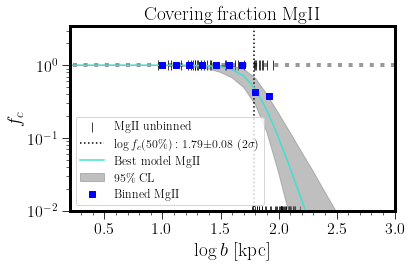

In [108]:
fc_isol_9 = run_covering_2_isol.mgii(run = True, filename = isol_folder+"isol_9.csv", with_outliers= "",\
                             redshift = False, mass = False, sfr = False, errorbar = False)

MgII_closest
Reading from None
LEN (Outcomes) 72


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:03<00:00, 2947.10draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.702864 -6.413221 -4.846491 -3.579891 -2.543356 -1.703196
beta   1.228209  0.637354  1.027134  1.268653  1.436513  1.553569
alpha -3.6 [-6.41--1.71] (95\%) 
beta 1.3 [0.64-1.55] (95\%) 

WAIC 44.54 +/- 11.84 peff 1.60
WAIC deviance 41.33375347918222
LOO 44.58 +/- 11.86 peff 1.62
WBIC  75.19104184716879
Deviance Lmax 44.5250
DIC Lmax 48.8026 2.14
Deviance best 44.5411
DIC best 48.7865 2.12
|               WAIC |               LOO |              WBIC |               DIC |
| 44.541937633388116 | 44.58193976468707 | 75.19104184716879 | 48.78645280127382 |
['alpha', 'beta']
           mean       2.5      16.0      50.0      84.0      97.5
alpha -3.702864 -6.413221 -4.846491 -3.579891 -2.543356 -1.703196
beta   1.228209  0.637354  1.027134  1.268653  1.436513  1.553569
evaluating for z= 0  and logm =  0  and log sfr =  0
best params:  <MultiTrace: 2 chains, 4000 iterations, 4 variables>
z, m, sfr valu

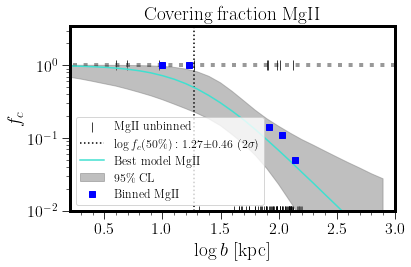

In [116]:
fc_isol_lowM = run_covering_2_isol.mgii(run = True, filename = isol_folder+"isol_lowM.csv", with_outliers= "",\
                             redshift = False, mass = False, sfr = False, errorbar = False)

MgII_closest
Reading from None
LEN (Outcomes) 144


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 9000/9000 [00:02<00:00, 3201.88draws/s]


['alpha', 'beta']
           mean      2.5      16.0      50.0      84.0      97.5
alpha -6.792887 -9.34844 -7.961164 -6.716873 -5.629009 -4.659581
beta   1.656234  1.55317  1.609070  1.659562  1.703688  1.741755
alpha -6.7 [-9.35--4.66] (95\%) 
beta 1.7 [1.55-1.74] (95\%) 

WAIC 99.74 +/- 14.11 peff 1.71
WAIC deviance 96.33130174295826
LOO 99.76 +/- 14.12 peff 1.71
WBIC  159.00952514152206
Deviance Lmax 100.5944
DIC Lmax 104.5814 1.99
Deviance best 100.5951
DIC best 104.5808 1.99
|              WAIC |               LOO |               WBIC |                DIC |
| 99.74293510454281 | 99.75791436936161 | 159.00952514152206 | 104.58075448758534 |
['alpha', 'beta']
           mean      2.5      16.0      50.0      84.0      97.5
alpha -6.792887 -9.34844 -7.961164 -6.716873 -5.629009 -4.659581
beta   1.656234  1.55317  1.609070  1.659562  1.703688  1.741755
evaluating for z= 0  and logm =  0  and log sfr =  0
best params:  <MultiTrace: 2 chains, 4000 iterations, 4 variables>
z, m, sfr val

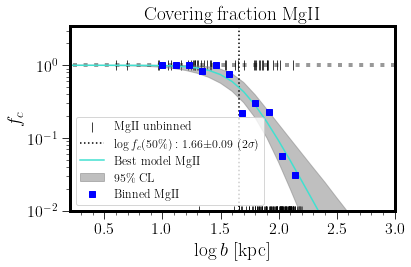

In [110]:
fc_isol = run_covering_2_isol.mgii(run = True, filename = isol_folder+"isol.csv", with_outliers= "",\
                             redshift = False, mass = False, sfr = False, errorbar = False)

In [117]:
# The ranges for the parameters:
logb = np.linspace(0.1, 2.5, 50)
logm = np.linspace(8, 12, 20)
logsfr = np.linspace(-3, 3, 20)
z_range = np.linspace(0.4, 1.5, 20)
logz = np.log10(1+z_range)
bb = 10**logb

# The fixed values to estimates the fc:
z = 1
Z = np.log10(1+z)
m = 10
sfr = 0

# The extraction of the low, middle, high values:
pbest_isol_9, plow_isol_9, phigh_isol_9 = \
    fc_isol_9.predict_2d(logb, params=fc_isol_9.trace)
pbest_isol_lowM, plow_isol_lowM, phigh_isol_lowM = \
    fc_isol_lowM.predict_2d(logb, params=fc_isol_lowM.trace)
pbest_isol, plow_isol, phigh_isol = \
    fc_isol.predict_2d(logb, params=fc_isol.trace)

best params:  <MultiTrace: 2 chains, 4000 iterations, 4 variables>
z, m, sfr values =  0 0 0
!!! IS INSTANCED !!!
best params:  <MultiTrace: 2 chains, 4000 iterations, 4 variables>
z, m, sfr values =  0 0 0
!!! IS INSTANCED !!!
best params:  <MultiTrace: 2 chains, 4000 iterations, 4 variables>
z, m, sfr values =  0 0 0
!!! IS INSTANCED !!!


In [112]:
def logistic_with_z(b, A, B, C, logz):
    t = A*(np.log10(b)- B*logz - C)
    P = 1/(1+np.exp(-t))
    return P

def logistic_no_z(b, A, C):
    t = A*(np.log10(b) - C)
    P = 1/(1+np.exp(-t))
    return P


z = 1
logz = np.log10(1+z)
param_01A_Ilane = [-4.2, 2, 1]
param_inf_Ilane = np.array([0, -0.7-2.0, 0.2-1.0])/2
param_sup_Ilane = np.array([0, 4.3-2.0, 1.9-1.0])/2
pp_Ilane = logistic_with_z(bb, param_01A_Ilane[0], param_01A_Ilane[1], param_01A_Ilane[2], logz)

# For the CL intervals:
Schroetter_fc_sup = pd.read_csv("Schroetter_fc_sup.csv", index_col = False)
Schroetter_fc_inf = pd.read_csv("Schroetter_fc_inf.csv", index_col = False)

Schroetter_fc50_sup = pd.read_csv("Schroetter_fc50_sup.csv", index_col = False)
Schroetter_fc50_inf = pd.read_csv("Schroetter_fc50_inf.csv", index_col = False)

z_range = np.linspace(0.4, 1.5, 20)
logz = np.log10(1+z_range)

z_range2 = np.linspace(np.min(Schroetter_fc50_sup["z_sup"]), np.max(Schroetter_fc50_sup["z_sup"]))
Sc_logb_sup = np.interp(logb, Schroetter_fc_sup["log_b_sup"], Schroetter_fc_sup["log_fc_sup"])
Sc_logb_inf = np.interp(logb, Schroetter_fc_inf["log_b_inf"], Schroetter_fc_inf["log_fc_inf"])
Sc_fc50_sup = np.interp(z_range2, Schroetter_fc50_sup["z_sup"], Schroetter_fc50_sup["log_fc50_sup"])
Sc_fc50_inf = np.interp(z_range2, Schroetter_fc50_inf["z_inf"], Schroetter_fc50_inf["log_fc50_inf"])

#pbestz_Ilane, plowz_Ilane, phighz_Ilane = \
#predict_z(logz, m = 0, sfr = 0, redshift = True, params=param_01A_Ilane, percentile=95, \
#         inf = param_inf_Ilane, sup = param_sup_Ilane)

Text(0, 0.5, '$f_c$')

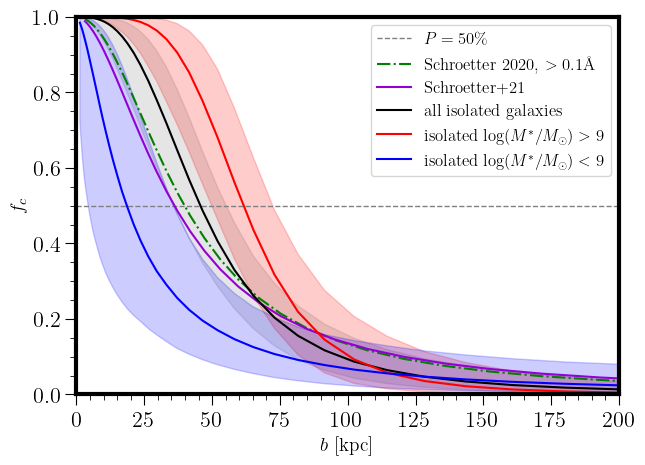

In [118]:
plt.figure(figsize = (7,5), dpi = 100)
plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter et al. 2021")
#plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "-", \
         color = "darkviolet", marker = " ", label = "Schroetter+21")

plt.fill_between(10**logb, plow_isol, phigh_isol, color = 'grey', alpha = 0.2)
plt.plot(10**logb, pbest_isol, label= "all isolated galaxies", color = "black")

plt.fill_between(10**logb, plow_isol_9, phigh_isol_9, color = 'red', alpha = 0.2)
plt.plot(10**logb, pbest_isol_9, label= "isolated log($M^*/M_{\odot})> 9$", color = "red")

plt.fill_between(10**logb, plow_isol_lowM, phigh_isol_lowM, color = 'blue', alpha = 0.2)
plt.plot(10**logb, pbest_isol_lowM, label= "isolated log($M^*/M_{\odot})< 9$", color = "blue")


#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12)
plt.ylim((0.0,1.0))
plt.xlim((0,200))

plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")

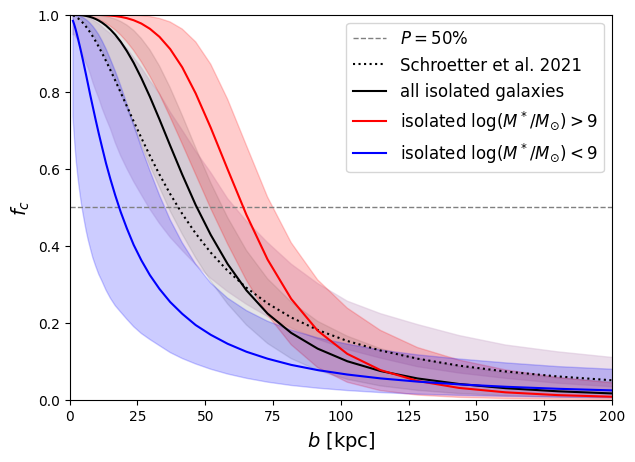

In [48]:
np.median(isol_9["Z"])

0.8873200000000001

# Combined plot

Text(0, 0.5, '$f_c$')

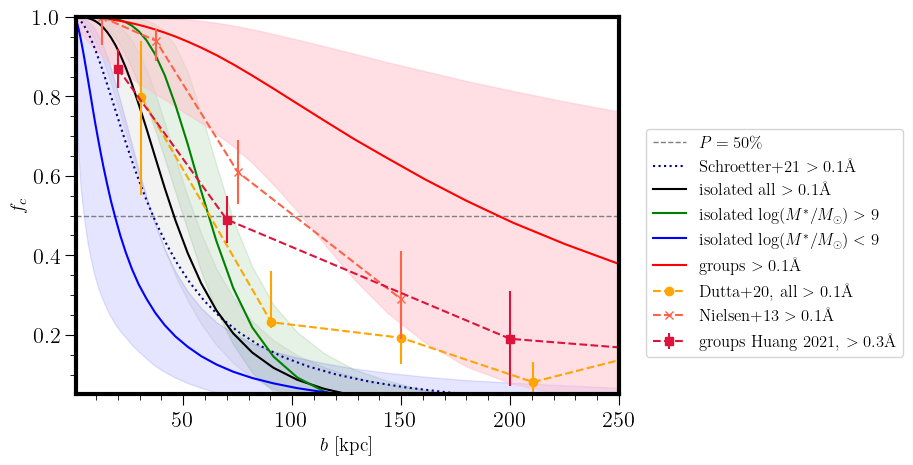

In [174]:
plt.figure(figsize = (7,5), dpi = 100)
plt.rcParams['lines.linewidth']=1.5
#plt.axhline(0.0, color = "grey", linestyle = "--")
#plt.axhline(1, color = "grey", linestyle = "--")
plt.axhline(0.5, color = "gray", linestyle = "--", linewidth = 1, label = "$P = 50\%$")

#plt.plot(10**logb, pp_Ilane, color = "black", linestyle = "dotted", label = "Schroetter et al. 2021")
#plt.fill_between(10**logb, 10**Sc_logb_inf, 10**Sc_logb_sup, color = 'thistle', alpha = 0.5)
#plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_b"], linestyle = "-.",  color = "green", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
plt.plot(10**Schroetter_2021["logb"], Schroetter_2021["best_fit_bz"], linestyle = "dotted", \
         color = "darkblue", marker = " ", label = "Schroetter+21 $> 0.1$\AA")


plt.fill_between(10**logb, plow_isol, phigh_isol, color = 'grey', alpha = 0.1)
plt.plot(10**logb, pbest_isol, label= "isolated all $> 0.1$\AA", color = "black")

plt.fill_between(10**logb, plow_isol_9, phigh_isol_9, color = 'green', alpha = 0.1)
plt.plot(10**logb, pbest_isol_9, label= "isolated log($M^*/M_{\odot})> 9$", color = "green")

plt.fill_between(10**logb, plow_isol_lowM, phigh_isol_lowM, color = 'blue', alpha = 0.1)
plt.plot(10**logb, pbest_isol_lowM, label= "isolated log($M^*/M_{\odot})< 9$", color = "blue")

plt.fill_between(10**logb, plow_G4_9_bmin_noz, phigh_G4_9_bmin_noz, color = 'pink', alpha = 0.5)
plt.plot(10**logb, pbest_G4_9_bmin_noz, label= "groups $> 0.1$\AA", color = "red")

plt.plot(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01"], linestyle = "--", \
            marker = "o", label = "Dutta+20, all $> 0.1$\AA", color = "orange")
plt.vlines(Dutta_2020_fcdiff01["R(kpc)"], Dutta_2020_fcdiff01["fc01_inf"], Dutta_2020_fcdiff01["fc01_sup"],\
           color = "orange")

#Nielsen 2013
plt.plot(Nielsen_2013["b"], Nielsen_2013["fc01"], color = "tomato", marker = "x", \
         linestyle = '--', label = "Nielsen+13 $> 0.1$\AA")
plt.vlines(Nielsen_2013["b"], Nielsen_2013["fc01_inf"], Nielsen_2013["fc01_sup"], color = "tomato")

plt.errorbar(Huang_2021["b"], Huang_2021["all"], yerr= Huang_2021["all_sigma"],\
             linestyle = '--', color = "crimson", marker = "s", label = "groups Huang 2021, $> 0.3$\AA")


#plt.plot(Schroetter_2020["logb"], Schroetter_2020["best_fit_bz"], linestyle = "-.",  color = "darkviolet", marker = " ", label = "Schroetter 2020, $> 0.1$\AA")
#plt.legend(bbox_to_anchor=(0.5, 1.25), loc = 'center', ncol = 2)
plt.legend(fontsize = 12, loc=(1.05,0.1))
plt.ylim((0.05,1.0))
plt.xlim((1,250))

plt.xlabel("$b$ [kpc]", size = 14)
plt.ylabel("$f_c$", size = 14)
#plt.yscale("log")
#plt.xscale("log")